In [2]:
import pandas as pd
import numpy as np 
import math as mt
import s3fs
import zipfile
import os
import matplotlib.pyplot as plt

class s3_connection():
    def __init__(self):
        """
        établir la connexion et après utiliser les fonction de read et write 
        """
        try:
         s3 = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
         
         print("connection successful")
         
        except:
         s3="connection not established, debug "
         print(s3)
        self.s3=s3
    def listt(self, directory):
        return((self.s3.ls(directory)))

    def unzip(self,from_s,to_s):
      with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to_path)

    
    def from_pandas_to_parquet_store_in_s3(self,df, directory):
      try:
        with self.s3.open(directory, "wb") as file_out:
         df.to_parquet(file_out)
      except: 
        print("Cher lecteur, cette fonction écrit dans le dossier spécifié, mais vous n'avez pas les droits :( ")
      
    
    def get_tables_from_s3(self,directory):
        
        with self.s3.open(directory, "rb") as file_in:
          df = pd.read_parquet(file_in)
        return df
 

In [15]:
  
    
s3=s3_connection()
directory="aayrapetyan/diffusion/"
tables=s3.listt(directory)

dataframes = {}
words_to_remove = ["aayrapetyan", "diffusion", ".us", "--", "usd-spot","parquet"]
import re
# Loop through all files in the folder
for file_name in tables:
    if file_name.endswith('.parquet') and "final_table" not in file_name:  # Check if the file is a Parquet file
        
        try:
            # Read the Parquet file into a DataFrame
            df = s3.get_tables_from_s3(file_name)
            # Store the DataFrame using the file name (without extension) as the key
            pattern = "|".join(re.escape(word) for word in words_to_remove)
            cleaned_string = re.sub(pattern, "", file_name)
            cleaned_string = re.sub(r"[/\.]+", "/", cleaned_string).strip("/")[0:-1]
            dataframes[cleaned_string] = df
            print(f"Loaded {file_name} successfully!")
        except Exception as e:
            print(f"Error loading {file_name}: {e}")

for key in dataframes.keys():
    print(key)

dataframes["ftx-dai"]

connection successful
Loaded aayrapetyan/diffusion/binance.us-dai-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/binance.us-usdc-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/binance.us-usdt-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/coinbase-dai-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/coinbase-usdt-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/coinbase-wluna-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/ftx-cusdt-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/ftx-dai-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/ftx-luna-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/kraken-dai-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/kraken-luna-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/kraken-usdc-usd-spot.parquet successfully!
Loaded aayrapetyan/diffusion/kraken-usdt-usd-spot.parquet successfully!
binance-dai
binance-usdc
binance-us

,market,time,coin_metrics_id,amount,price,database_time,side
0,ftx-dai-usd-spot,2022-01-01 00:19:59.720191+00:00,2953428441,3028.9,1.0,2022-01-01 00:20:00.075013+00:00,buy
1,ftx-dai-usd-spot,2022-01-01 00:19:59.720191+00:00,2953428442,2000.0,1.0,2022-01-01 00:20:00.075013+00:00,buy
2,ftx-dai-usd-spot,2022-01-01 00:19:59.720191+00:00,2953428443,1.0,1.0,2022-01-01 00:20:00.075013+00:00,buy
3,ftx-dai-usd-spot,2022-01-01 00:19:59.720191+00:00,2953428444,5.0,1.0,2022-01-01 00:20:00.075013+00:00,buy
4,ftx-dai-usd-spot,2022-01-01 00:19:59.720191+00:00,2953428445,2150.2,1.0,2022-01-01 00:20:00.075013+00:00,buy
...,...,...,...,...,...,...,...
126811,ftx-dai-usd-spot,2022-11-12 03:22:06.088667+00:00,5412623105,29.1,1.013,2022-11-12 03:22:06.375870+00:00,sell
126812,ftx-dai-usd-spot,2022-11-12 03:22:06.224272+00:00,5412623109,49.4,1.013,2022-11-12 03:22:06.375870+00:00,sell
126813,ftx-dai-usd-spot,2022-11-12 03:22:06.258189+00:00,5412623113,29.5,1.013,2022-11-12 03:22:06.375870+00:00,sell
126814,ftx-dai-usd-spot,2022-11-12 03:22:06.354345+00:00,5412623119,42.2,1.013,2022-11-12 03:22:06.625909+00:00,sell


In [4]:
def remove_outliers(df, columns):
    """
    Remove outliers from the specified columns of a DataFrame.
    Outliers are defined as values that are more than 3 standard deviations away from the mean.
    Prints the number of outliers removed for each column.
    """
    for column in columns:
        if column in df.columns:
            # Calcul des bornes
            mean = df[column].mean()
            std = df[column].std()
            lower_bound = mean - 3 * std
            upper_bound = mean + 3 * std
            
            # Calcul du nombre de valeurs initiales
            initial_count = len(df)
            
            # Filtrage des valeurs dans les bornes
            df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
            
            # Nombre de valeurs supprimées
            final_count = len(df)
            print(f"{column}: {initial_count - final_count} outliers removed")
            
    return df


def mark_outliers(df, columns):
    """
    Mark outliers in the specified columns of a DataFrame.
    Outliers are defined as values that are more than 3 standard deviations away from the mean.
    A new column '{column}_outlier' is added, initialized to 0, and set to 1 if the value is an outlier.
    """
    df = df.copy()  # Pour éviter de modifier l'original directement
    
    for column in columns:
        if column in df.columns:
            # Calcul des bornes
            mean = df[column].mean()
            std = df[column].std()
            lower_bound = mean - 3 * std
            upper_bound = mean + 3 * std

            # Création de la colonne binaire d'outliers
            df[f"{column}_outlier"] = ((df[column] < lower_bound) | (df[column] > upper_bound)).astype(int)

            # Nombre d'outliers détectés
            outlier_count = df[f"{column}_outlier"].sum()
            print(f"{column}: {outlier_count} outliers marked")
    
    return df


In [5]:
# def plot_stablecoin_prices(stablecoin, title,dataframes):
#     plt.figure(figsize=(30, 6))
#     # for platform, df in dataframes_dict.items():
#     #     if stablecoin in platform:
#     plt.plot(dataframes[stablecoin]['time'], dataframes[stablecoin]['price'])
#     plt.xlabel('Time')
#     plt.ylabel('Price')
#     plt.title(title)
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# import matplotlib.pyplot as plt

def plot_stablecoin_prices(stablecoin, title, dataframes):
    """
    Plots stablecoin prices over time.
    If the outlier column exists, normal values are plotted in blue and outliers in red.
    Otherwise, the function plots all values in a single color.
    """
    plt.figure(figsize=(30, 6))
    
    df = dataframes[stablecoin]

    print(df.columns)
    
    if f"price_outlier" in df.columns:
        print("ok")
        # Séparer les valeurs normales et les outliers
        normal_values = df[df[f"price_outlier"] == 0]
        outliers = df[df[f"price_outlier"] == 1]

        # Tracer les valeurs normales en bleu
        plt.plot(normal_values['time'], normal_values['price'], color='blue', label='Normal Values')

        # Tracer les outliers en rouge
        plt.scatter(outliers['time'], outliers['price'], color='red', label='Outliers', zorder=3)
    else:
        print("else")
        # Tracer normalement si la colonne outlier n'existe pas
        plt.plot(df['time'], df['price'], color='blue', label='Price')

    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


In [6]:
def plot_stablecoin_prices_multi(stablecoins, title, dataframes):
    """
    Trace les prix de plusieurs stablecoins sur le même graphique.
    """
    
    plt.figure(figsize=(32, 6))
    for stablecoin in stablecoins:
        if stablecoin in dataframes:
            df = dataframes[stablecoin]
            plt.plot(df['time'], df['price'], label=stablecoin)

    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# Etude de DAI

## Avant la rejection des outliers

Index(['market', 'time', 'coin_metrics_id', 'amount', 'price', 'database_time',
       'side'],
      dtype='object')
else


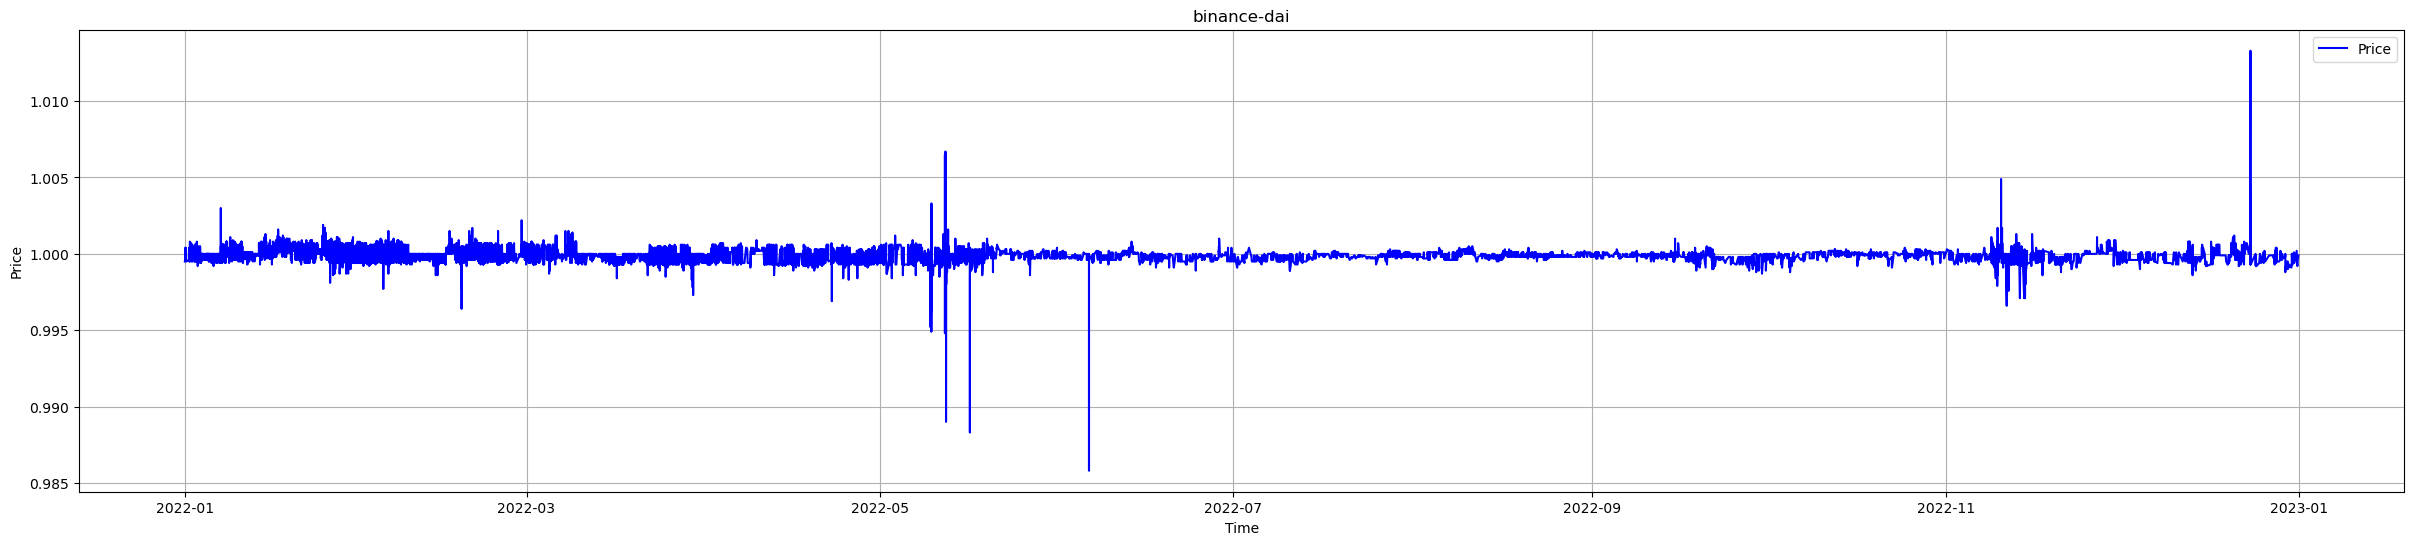

Index(['market', 'time', 'coin_metrics_id', 'amount', 'price', 'database_time',
       'side'],
      dtype='object')
else


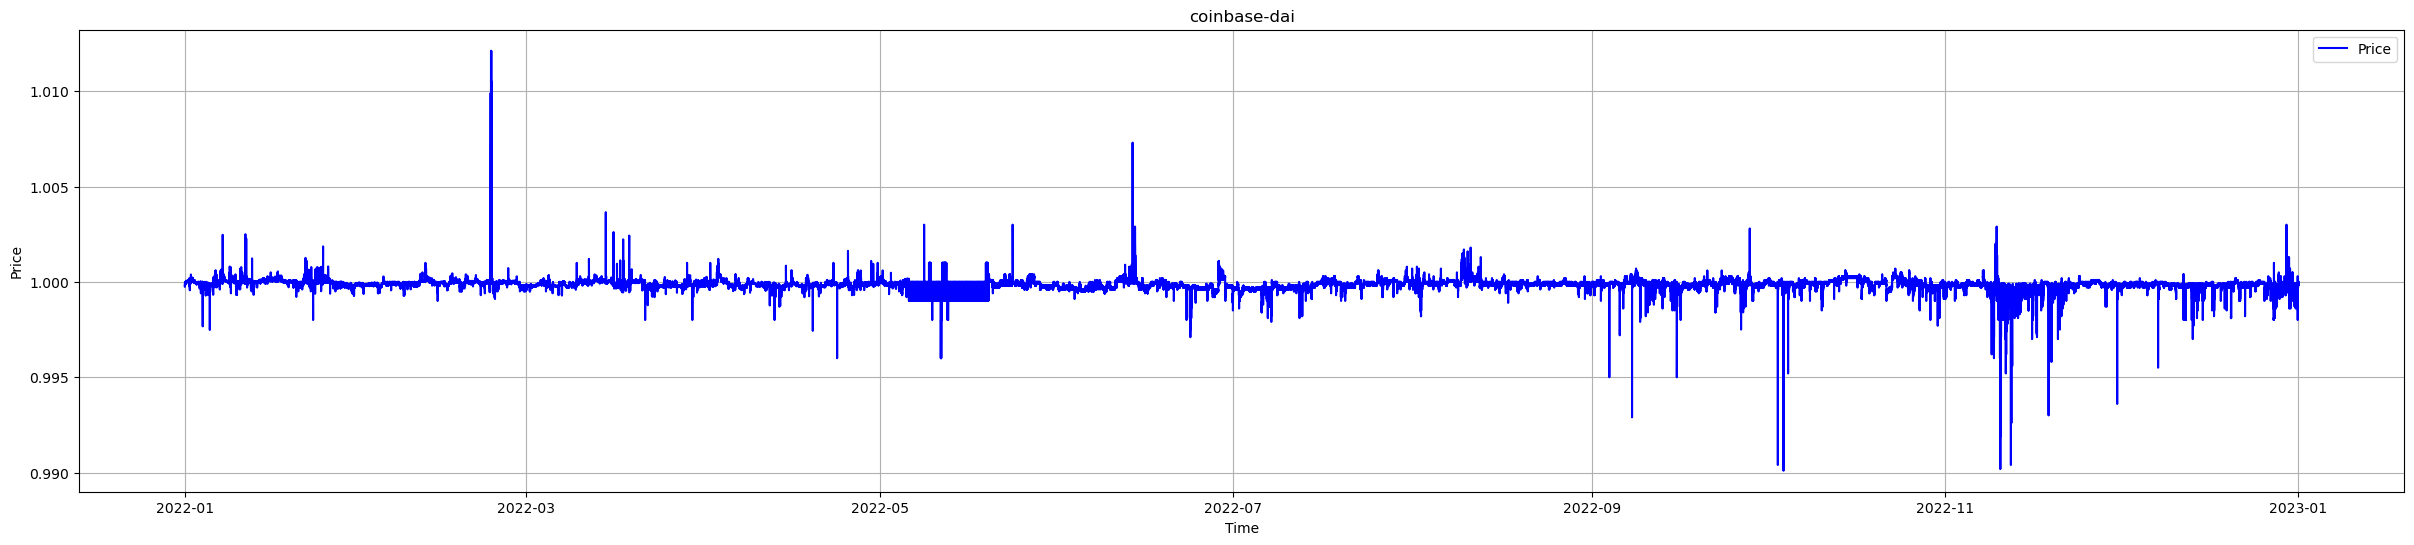

Index(['market', 'time', 'coin_metrics_id', 'amount', 'price', 'database_time',
       'side'],
      dtype='object')
else


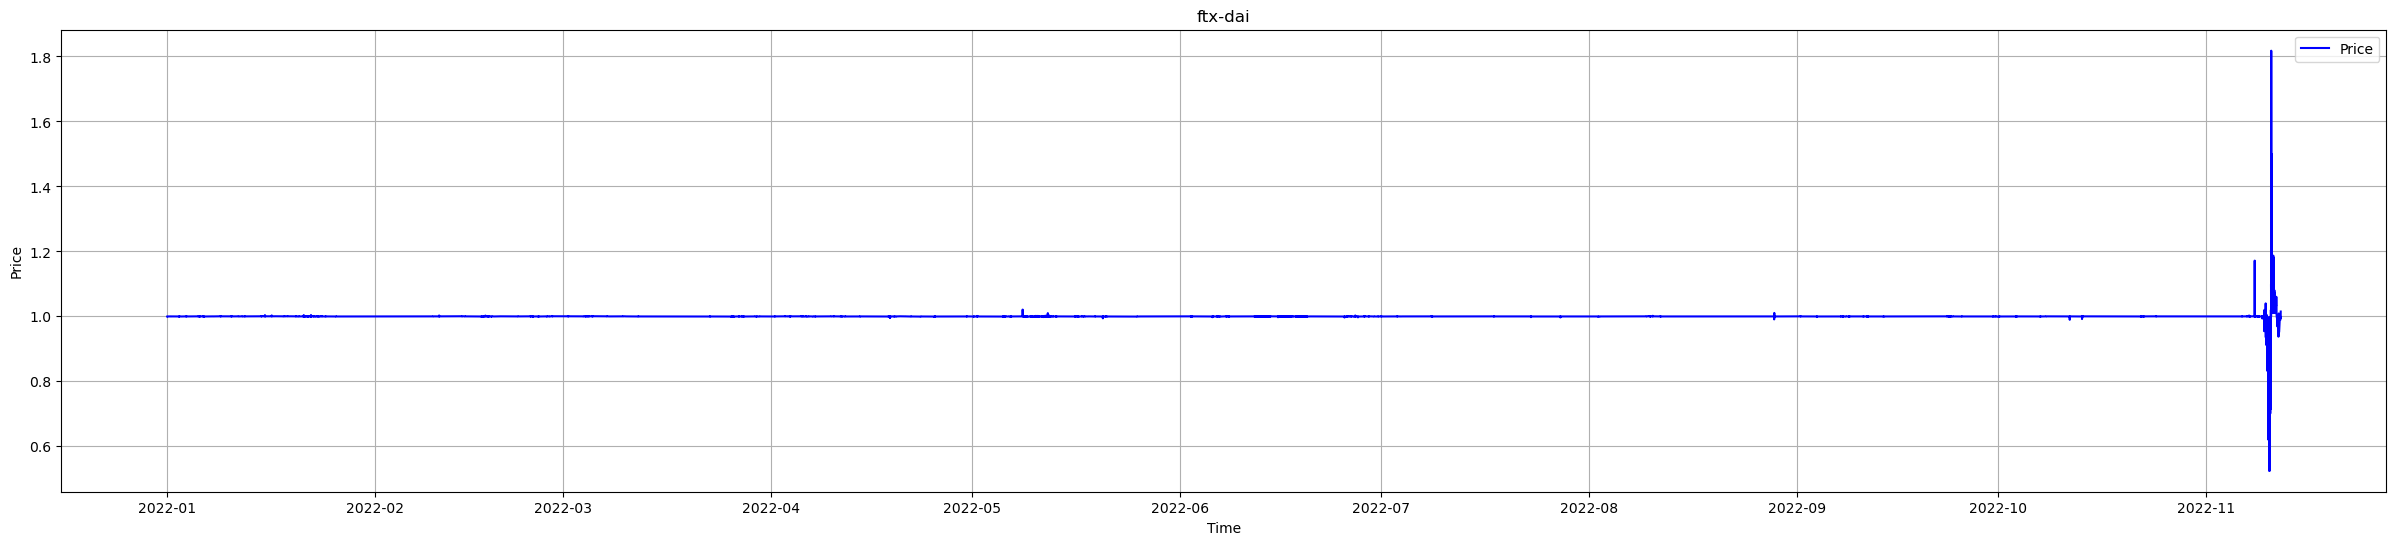

Index(['market', 'time', 'coin_metrics_id', 'amount', 'price', 'database_time',
       'side'],
      dtype='object')
else


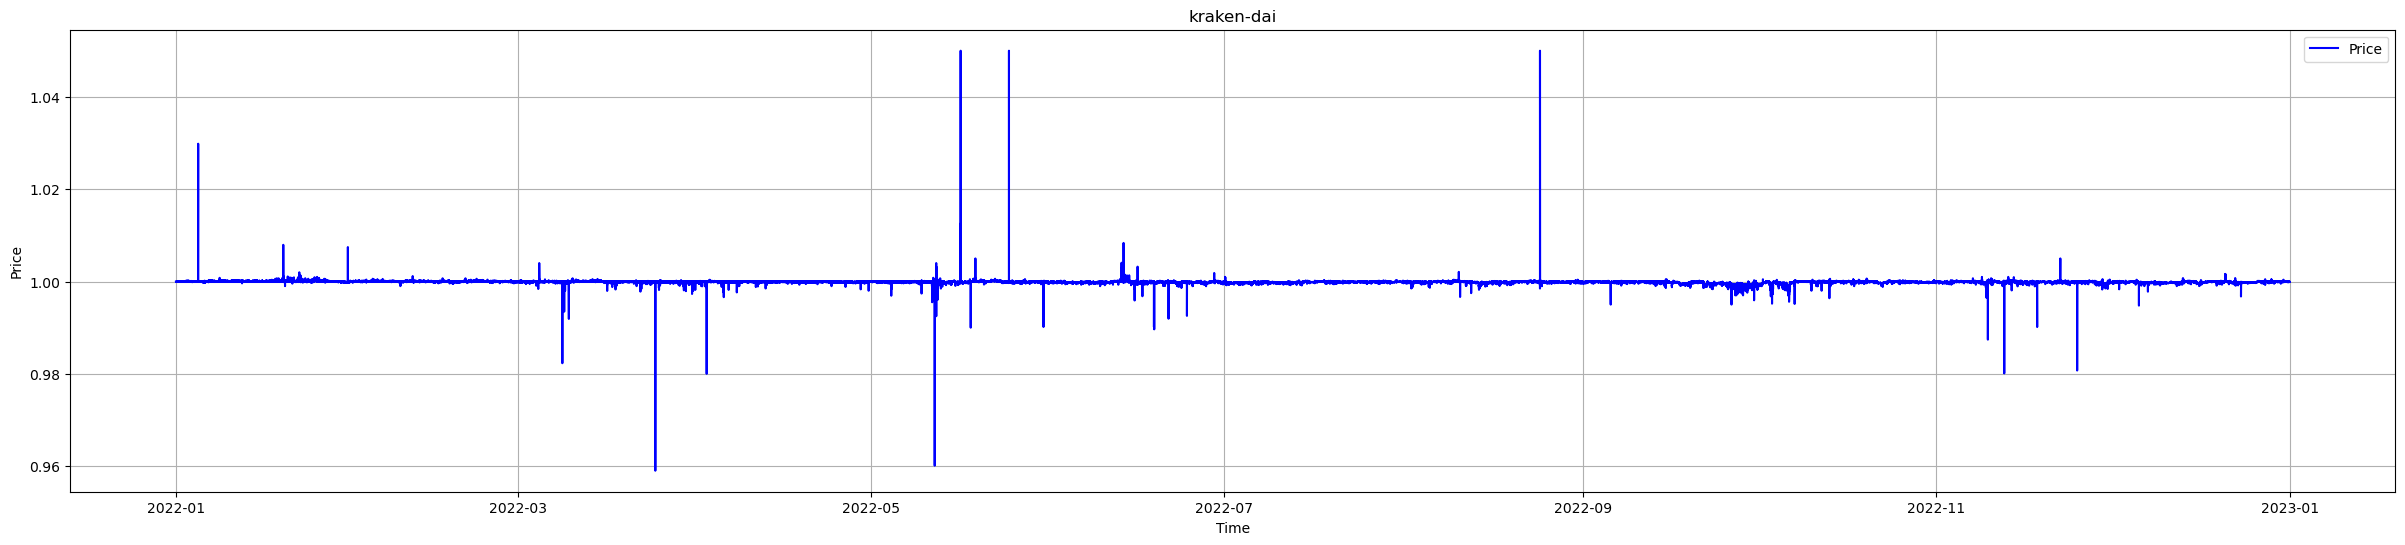

In [16]:
plot_stablecoin_prices("binance-dai","binance-dai",dataframes)
plot_stablecoin_prices("coinbase-dai","coinbase-dai",dataframes)
plot_stablecoin_prices("ftx-dai","ftx-dai",dataframes)
plot_stablecoin_prices("kraken-dai","kraken-dai",dataframes)

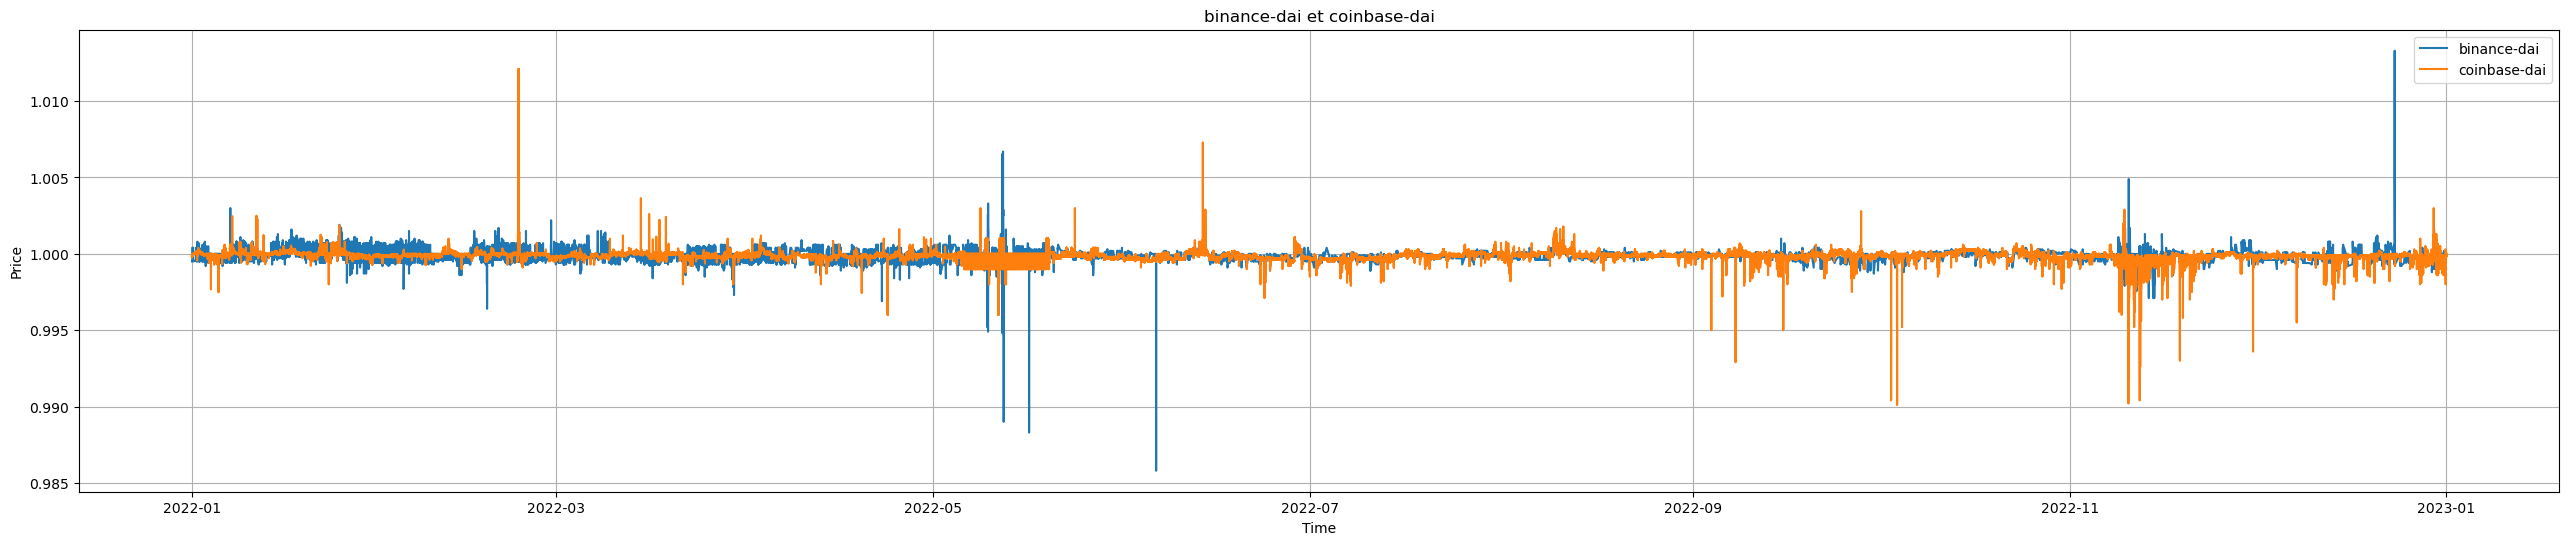

In [7]:
plot_stablecoin_prices_multi(["binance-dai","coinbase-dai"],"binance-dai et coinbase-dai",dataframes)

## Après la rejection des outliers

In [7]:
dataframes["new-binance-dai"] = remove_outliers(dataframes["binance-dai"], ["price"])
dataframes["new-coinbase-dai"] = remove_outliers(dataframes["coinbase-dai"], ["price"])
dataframes["new-ftx-dai"] = remove_outliers(dataframes["ftx-dai"], ["price"])
dataframes["new-kraken-dai"] = remove_outliers(dataframes["kraken-dai"], ["price"])

dataframes["mark-binance-dai"] = mark_outliers(dataframes["binance-dai"], ["price"])
dataframes["mark-coinbase-dai"] = mark_outliers(dataframes["coinbase-dai"], ["price"])
dataframes["mark-ftx-dai"] = mark_outliers(dataframes["ftx-dai"], ["price"])
dataframes["mark-kraken-dai"] = mark_outliers(dataframes["kraken-dai"], ["price"])



price: 158 outliers removed
price: 107896 outliers removed
price: 1806 outliers removed
price: 16138 outliers removed
price: 158 outliers marked
price: 107896 outliers marked
price: 1806 outliers marked
price: 16138 outliers marked


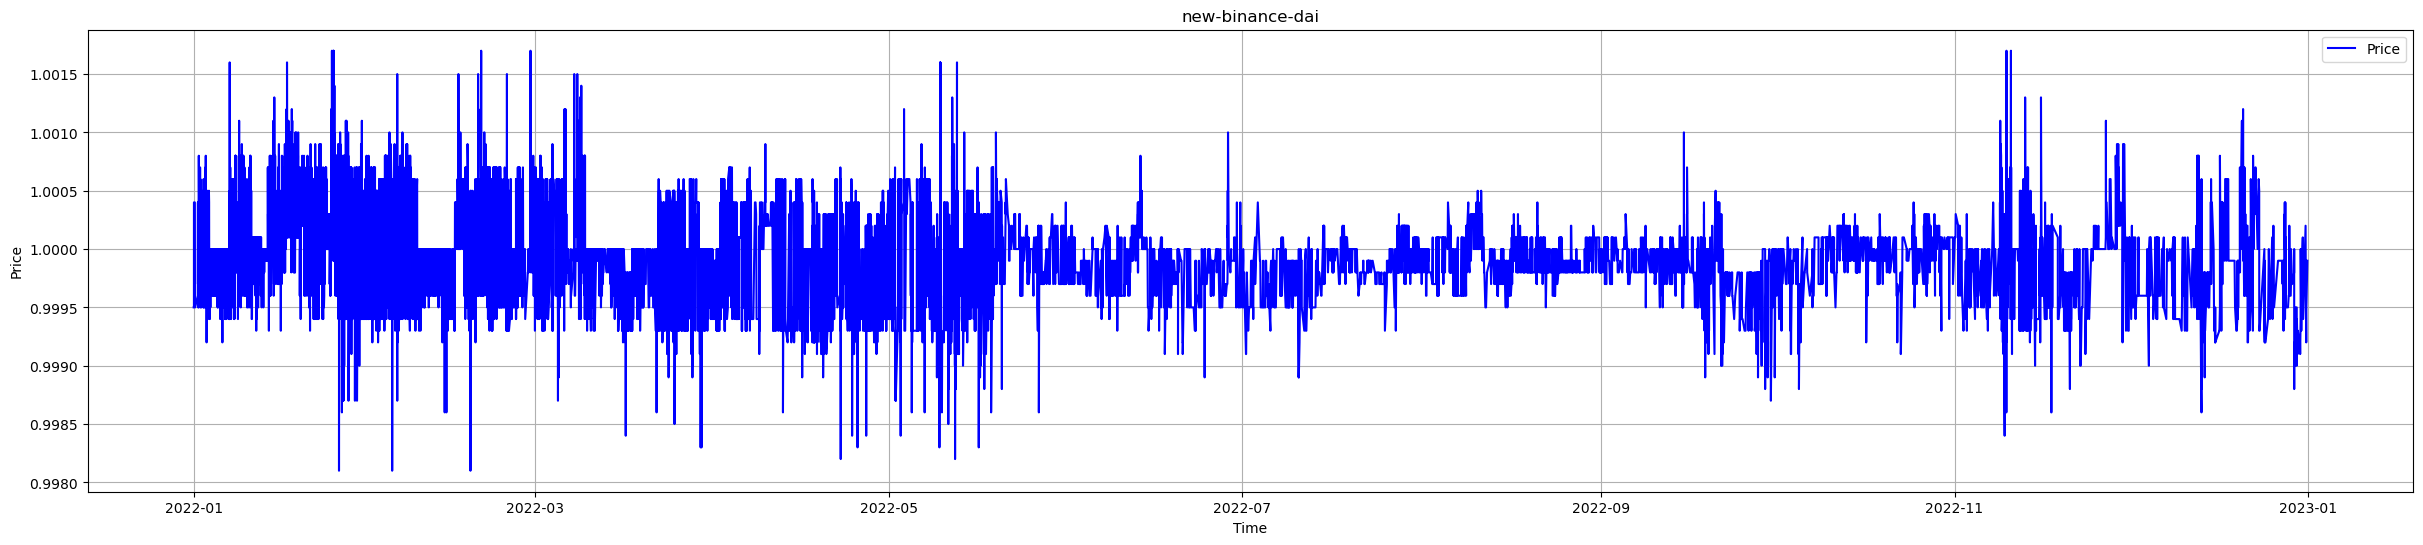

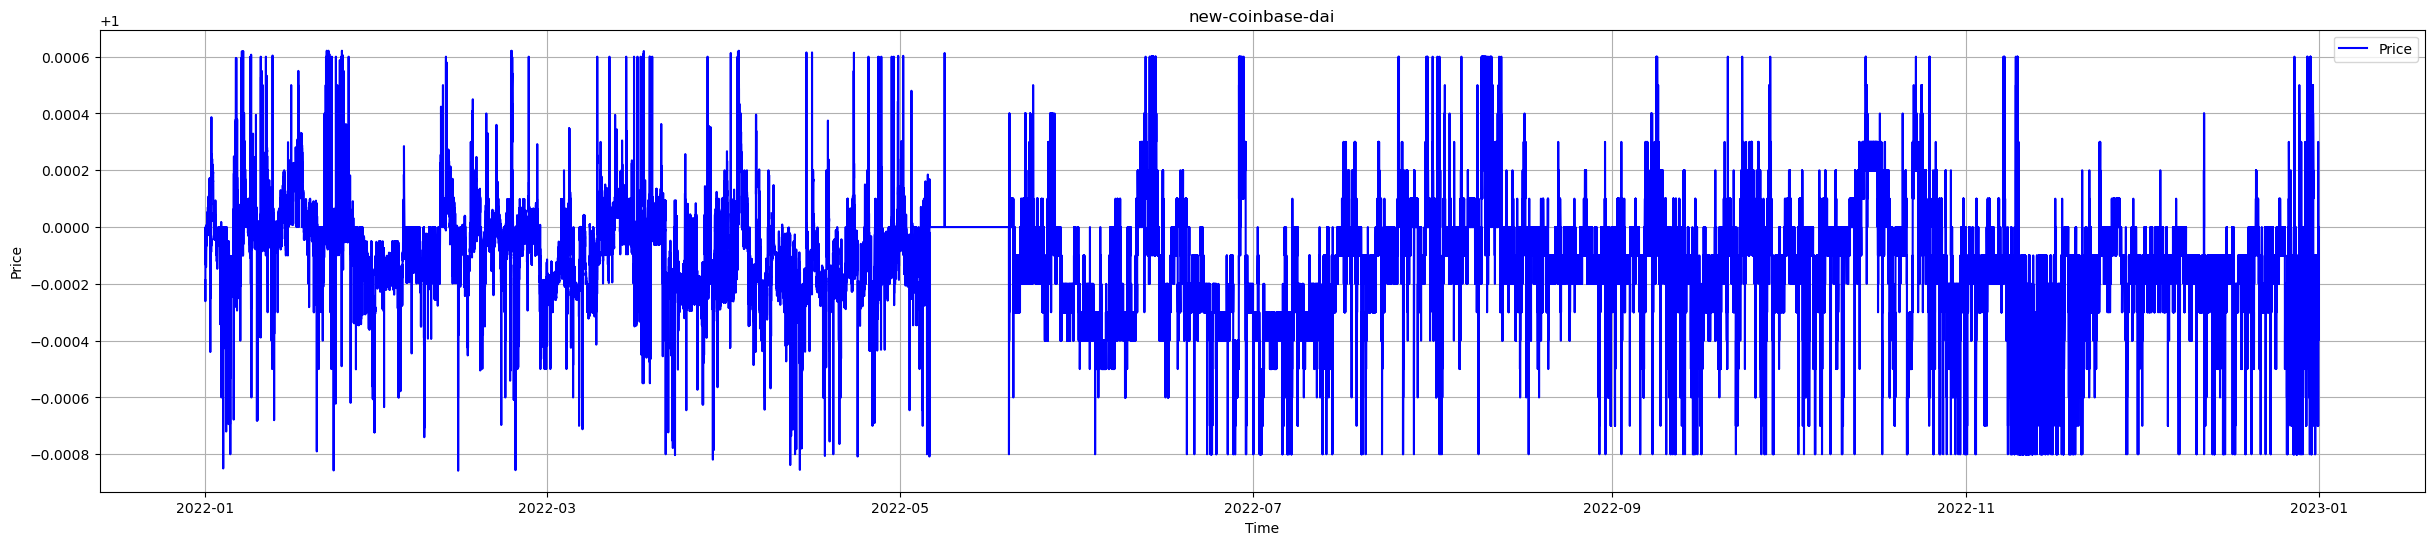

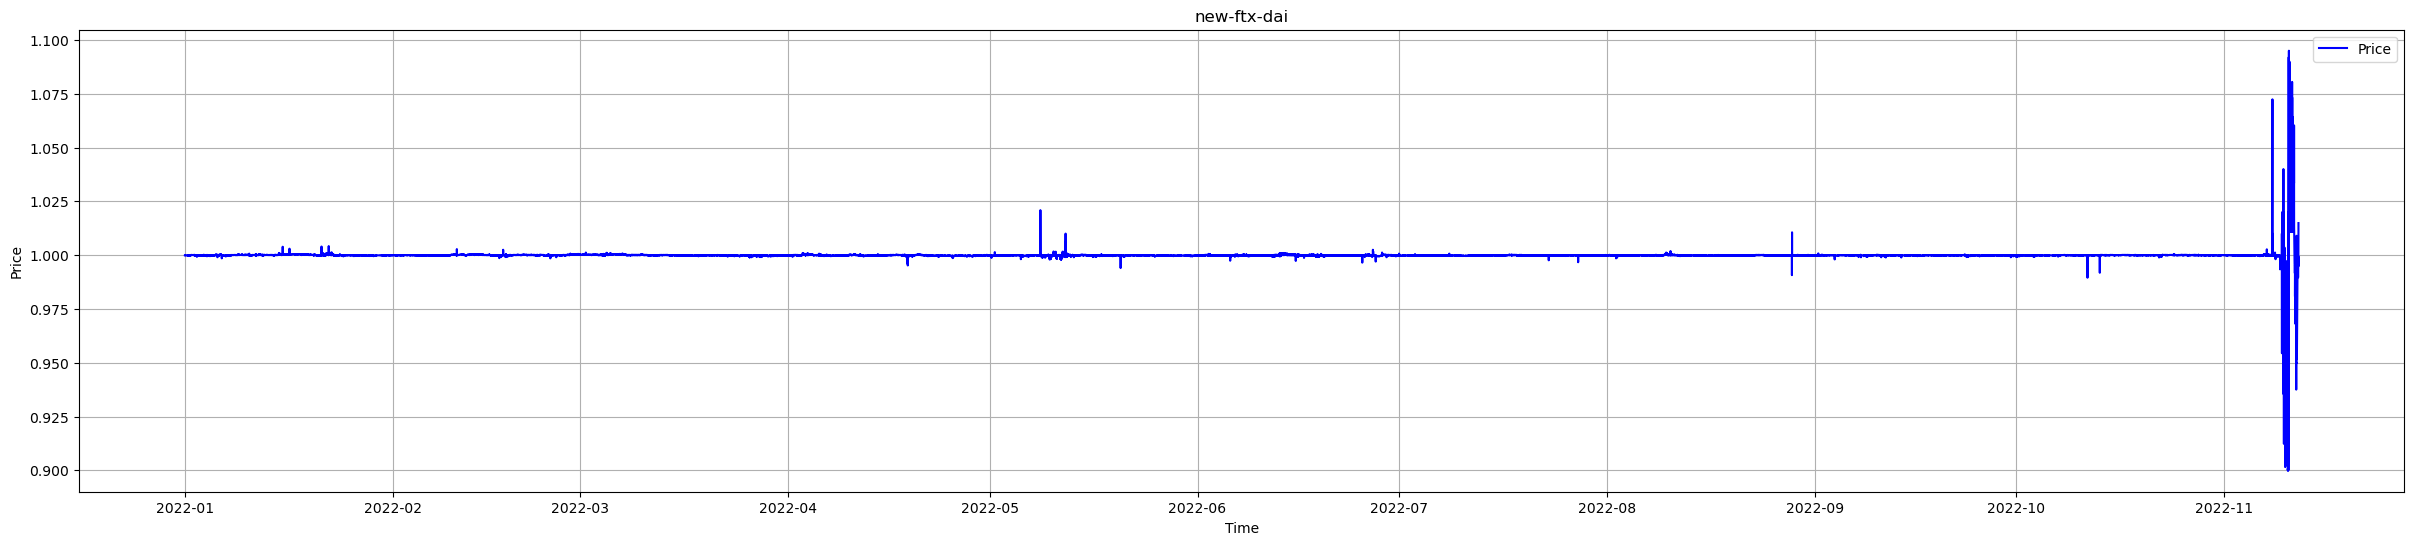

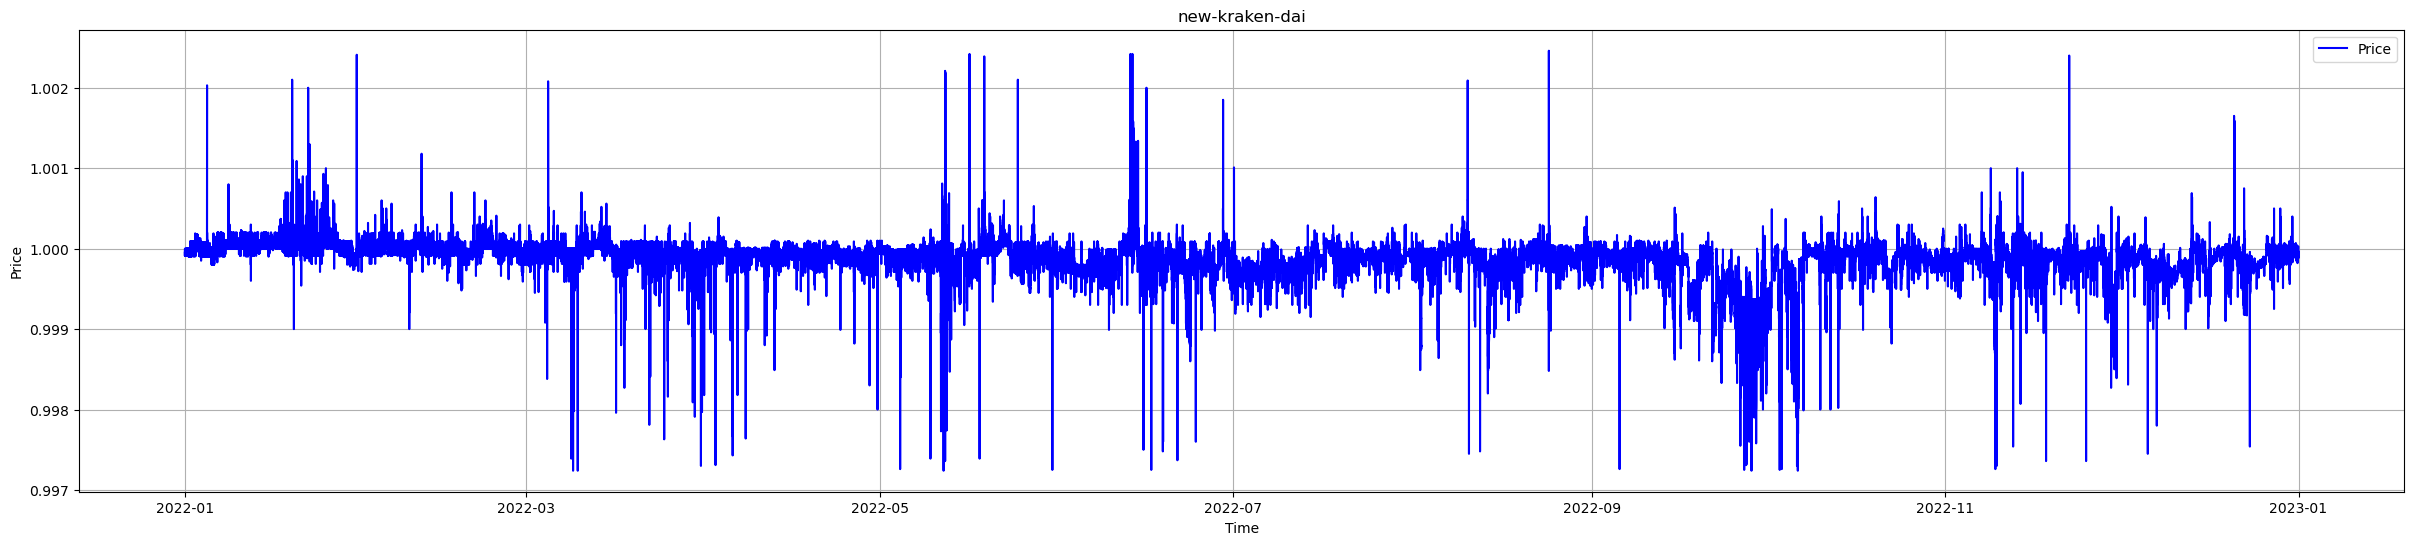

In [11]:
plot_stablecoin_prices("new-binance-dai","new-binance-dai",dataframes)
plot_stablecoin_prices("new-coinbase-dai","new-coinbase-dai",dataframes)
plot_stablecoin_prices("new-ftx-dai","new-ftx-dai",dataframes)
plot_stablecoin_prices("new-kraken-dai","new-kraken-dai",dataframes)



In [15]:
dataframes["mark-binance-dai"]

,market,time,coin_metrics_id,amount,price,database_time,side,price_outlier
0,binance.us-dai-usd-spot,2022-01-01 00:20:22.742000+00:00,102202,63.28,0.9995,2022-01-01 00:20:22.865667+00:00,sell,0
1,binance.us-dai-usd-spot,2022-01-01 00:20:24.742000+00:00,102203,63.27,0.9995,2022-01-01 00:20:24.866545+00:00,sell,0
2,binance.us-dai-usd-spot,2022-01-01 00:20:25.741000+00:00,102204,63.27,0.9995,2022-01-01 00:20:25.867392+00:00,sell,0
3,binance.us-dai-usd-spot,2022-01-01 01:00:32.739000+00:00,102205,48.5,0.9995,2022-01-01 01:00:32.849957+00:00,sell,0
4,binance.us-dai-usd-spot,2022-01-01 01:14:43.992000+00:00,102206,100.0,0.9995,2022-01-01 01:14:44.241159+00:00,sell,0
...,...,...,...,...,...,...,...,...
17701,binance.us-dai-usd-spot,2022-12-31 17:16:00.243000+00:00,119903,75.0,0.9992,2022-12-31 17:16:00.314113+00:00,sell,0
17702,binance.us-dai-usd-spot,2022-12-31 17:53:03.318000+00:00,119904,2232.55,0.9995,2022-12-31 17:53:03.455808+00:00,sell,0
17703,binance.us-dai-usd-spot,2022-12-31 21:46:09.206000+00:00,119905,24.16,0.9999,2022-12-31 21:46:09.426908+00:00,sell,0
17704,binance.us-dai-usd-spot,2022-12-31 21:48:27.606000+00:00,119906,100.01,0.9999,2022-12-31 21:48:27.751530+00:00,sell,0


In [16]:
dataframes["mark-binance-dai"]["price_outlier"].value_counts()


price_outlier
0    17548
1      158
Name: count, dtype: int64

Index(['market', 'time', 'coin_metrics_id', 'amount', 'price', 'database_time',
       'side', 'price_outlier'],
      dtype='object')
ok


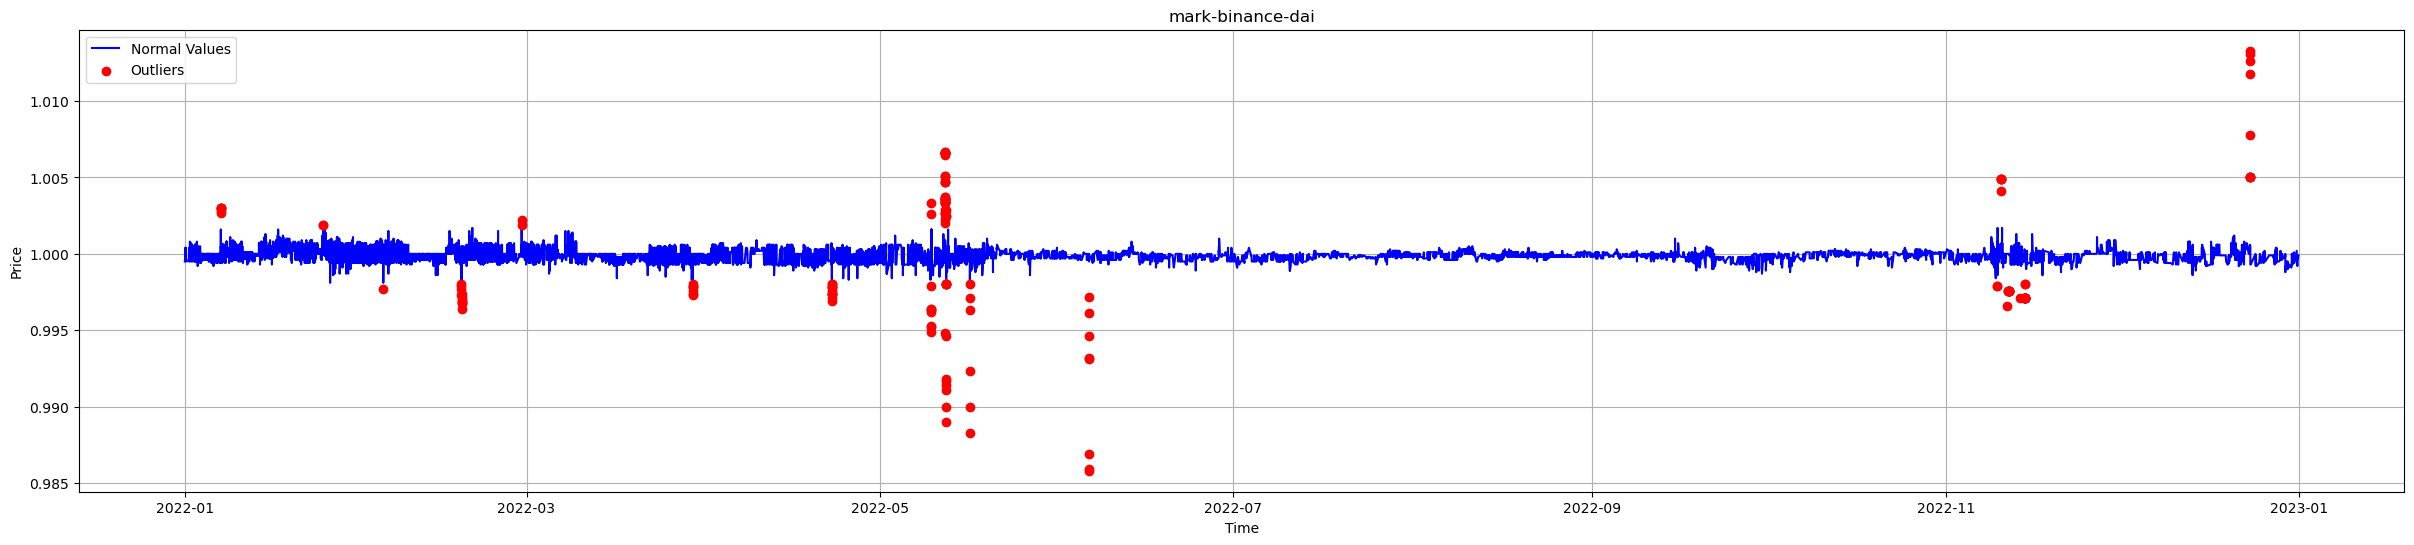

Index(['market', 'time', 'coin_metrics_id', 'amount', 'price', 'database_time',
       'side', 'price_outlier'],
      dtype='object')
ok


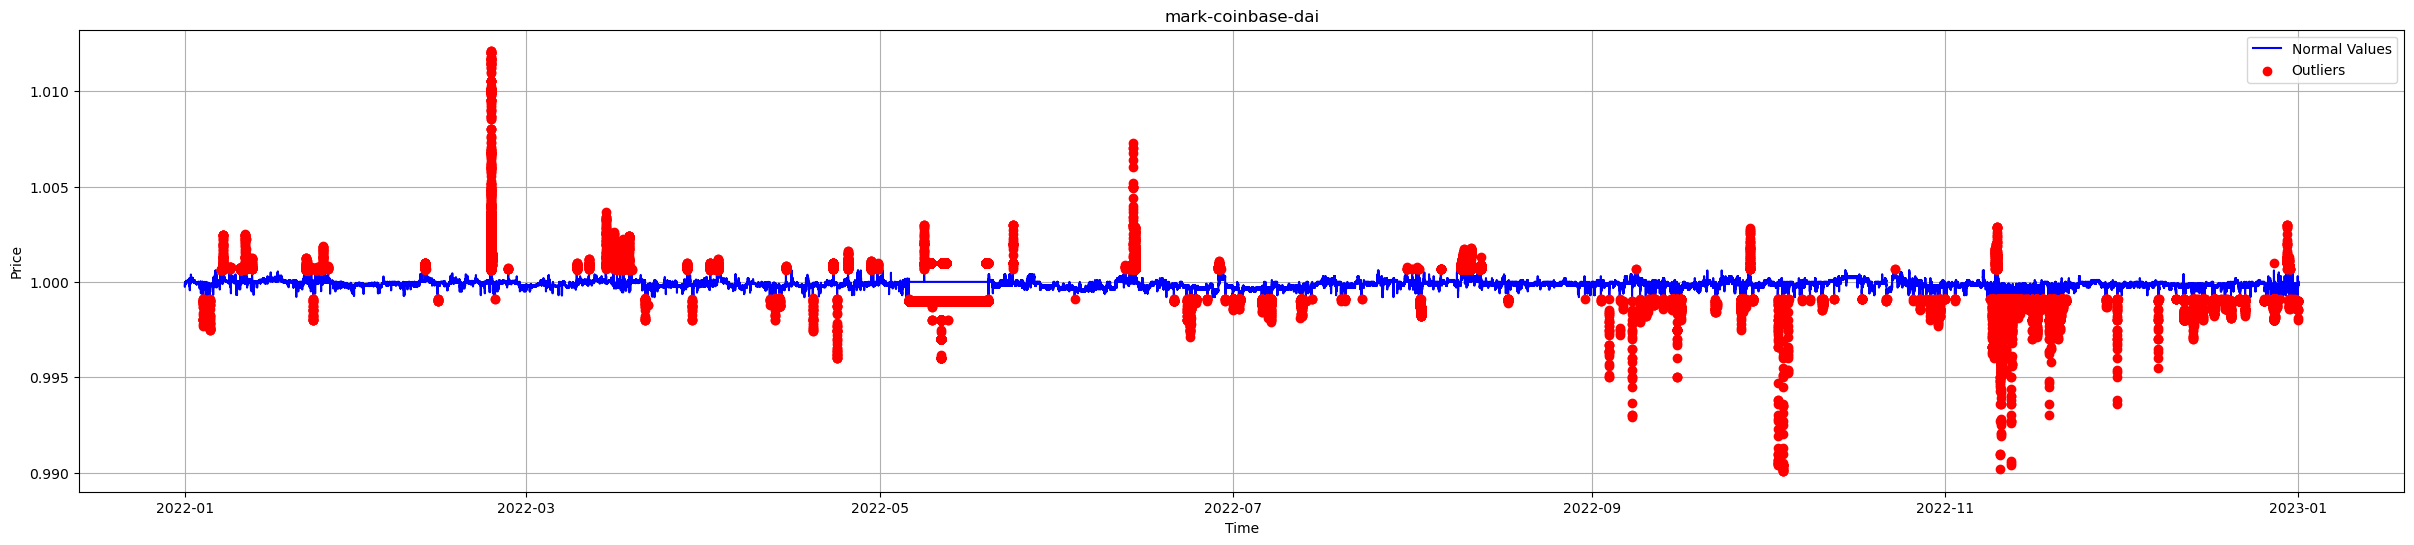

Index(['market', 'time', 'coin_metrics_id', 'amount', 'price', 'database_time',
       'side', 'price_outlier'],
      dtype='object')
ok


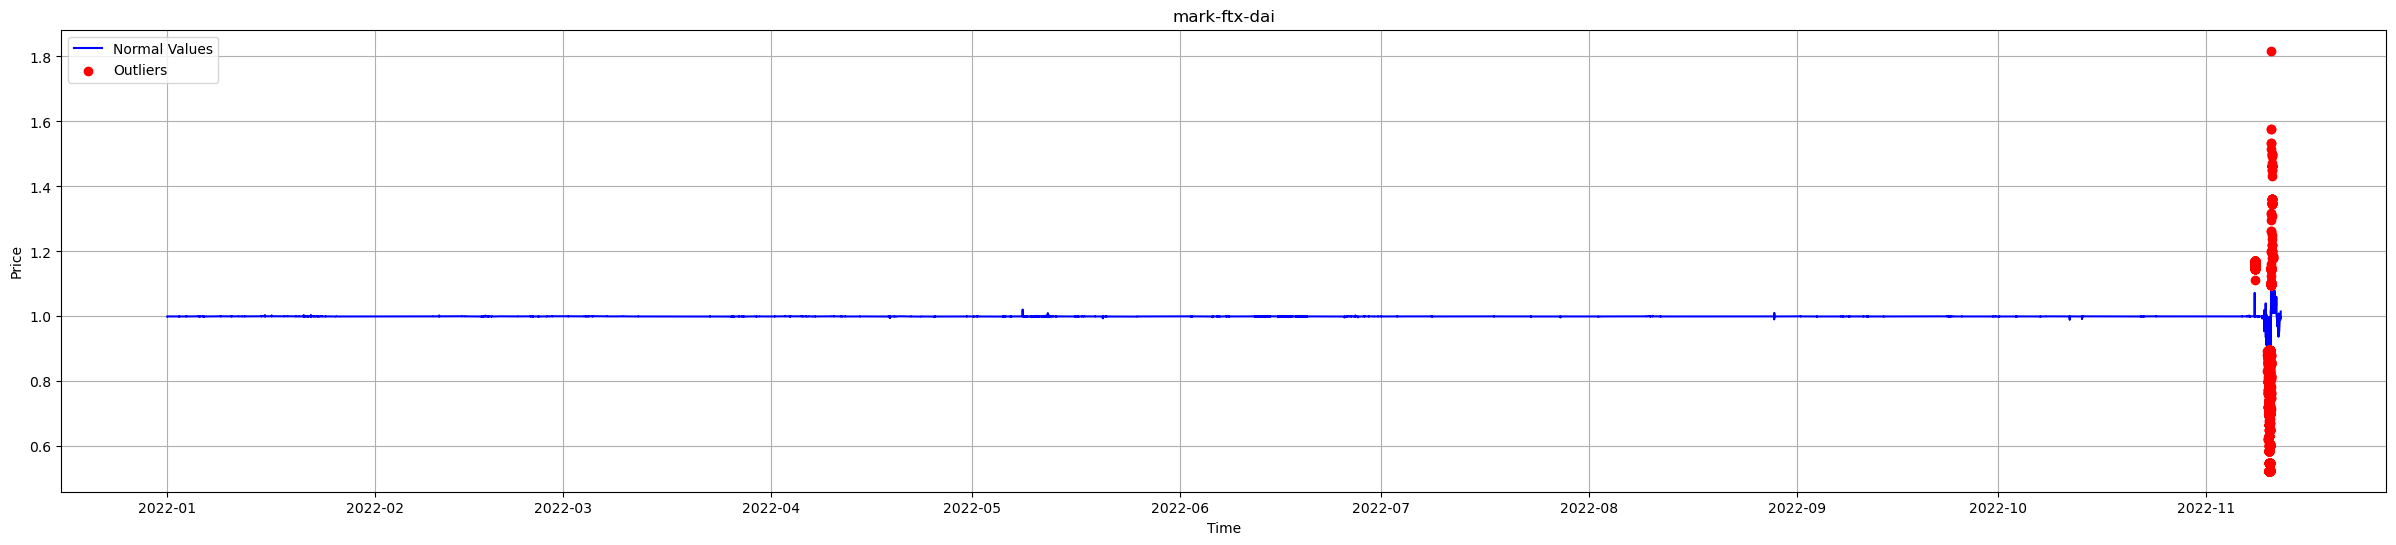

Index(['market', 'time', 'coin_metrics_id', 'amount', 'price', 'database_time',
       'side', 'price_outlier'],
      dtype='object')
ok


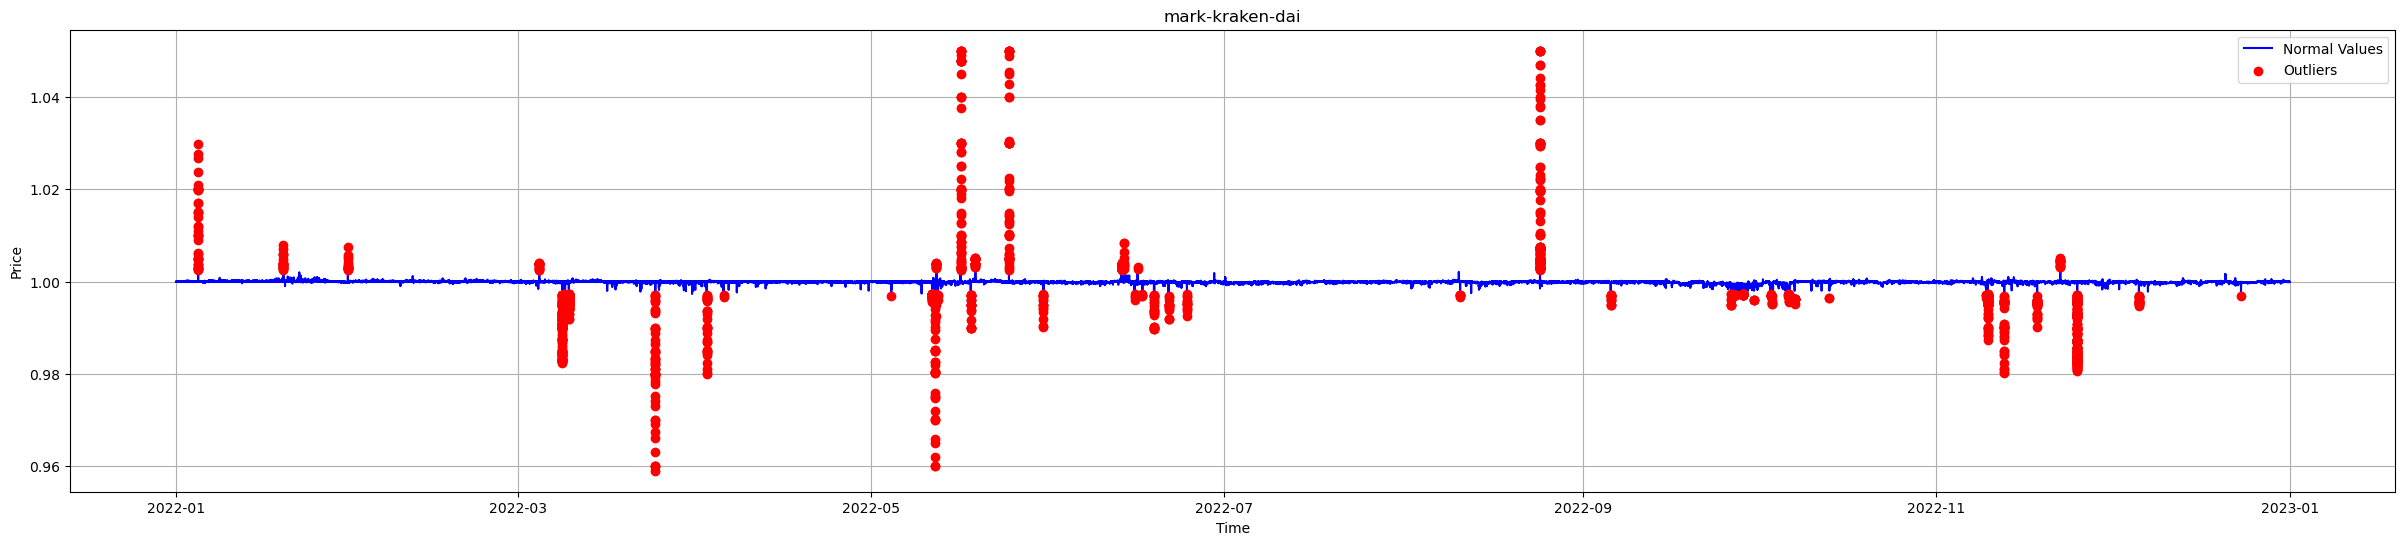

In [8]:
plot_stablecoin_prices("mark-binance-dai","mark-binance-dai",dataframes)
plot_stablecoin_prices("mark-coinbase-dai","mark-coinbase-dai",dataframes)
plot_stablecoin_prices("mark-ftx-dai","mark-ftx-dai",dataframes)
plot_stablecoin_prices("mark-kraken-dai","mark-kraken-dai",dataframes)

# On remarque qu'il ya déjà 2 périodes interessantes ou l'on a une pertubation du cours du dai sur les 4 plateformes : En mai 2022 et en novrembre 2022

In [10]:
def split_datasets_by_date(dataframes, stablecoin, date_ranges):
    """
    Splits the dataset into multiple subsets based on date ranges and updates the dataframes dictionary.

    Parameters:
    - dataframes (dict): Dictionnaire contenant les DataFrames des stablecoins.
    - stablecoin (str): Clé du DataFrame à traiter dans le dictionnaire.
    - date_ranges (list of tuples): Liste des plages de dates sous forme de tuples (start_date, end_date).

    Returns:
    - None: Met à jour directement le dictionnaire `dataframes`.
    """
    df = dataframes[stablecoin].copy()
    
    # Convertir la colonne 'time' en datetime si ce n'est pas déjà fait
    df['time'] = pd.to_datetime(df['time'])
    
    for start_date, end_date in date_ranges:
        subset = df[(df['time'] >= start_date) & (df['time'] <= end_date)]
        key = f"{stablecoin}_{start_date}_{end_date}"
        dataframes[key] = subset  # Ajout direct au dictionnaire principal
        
        print(f"Ajouté {key}: {len(subset)} lignes")

# Définition des plages de dates
date_ranges = [("2022-04-01", "2022-06-30"), ("2022-10-01", "2022-12-31")]

# Exécution de la fonction
split_datasets_by_date(dataframes, "mark-binance-dai", date_ranges)
split_datasets_by_date(dataframes, "mark-coinbase-dai", date_ranges)
# split_datasets_by_date(dataframes, "mark-ftx-dai", date_ranges)
# split_datasets_by_date(dataframes, "mark-kraken-dai", date_ranges)



Ajouté mark-binance-dai_2022-04-01_2022-06-30: 7111 lignes
Ajouté mark-binance-dai_2022-10-01_2022-12-31: 2143 lignes


Ajouté mark-coinbase-dai_2022-04-01_2022-06-30: 919542 lignes
Ajouté mark-coinbase-dai_2022-10-01_2022-12-31: 943734 lignes


In [12]:
dataframes["mark-binance-dai_2022-04-01_2022-06-30"]
# dataframes["mark-binance-dai_2022-10-01_2022-12-31"]


,market,time,coin_metrics_id,amount,price,database_time,side,price_outlier
6263,binance.us-dai-usd-spot,2022-04-01 00:17:58.039000+00:00,108465,50.01,0.9999,2022-04-01 00:17:58.222738+00:00,buy,0
6264,binance.us-dai-usd-spot,2022-04-01 00:25:37.953000+00:00,108466,170.56,0.9994,2022-04-01 00:25:38.066743+00:00,sell,0
6265,binance.us-dai-usd-spot,2022-04-01 01:41:37.019000+00:00,108467,999.1,0.9994,2022-04-01 01:41:37.089767+00:00,sell,0
6266,binance.us-dai-usd-spot,2022-04-01 02:32:31.137000+00:00,108468,134.8,0.9994,2022-04-01 02:32:31.237690+00:00,sell,0
6267,binance.us-dai-usd-spot,2022-04-01 03:53:10.883000+00:00,108469,60.12,0.9999,2022-04-01 03:53:11.133437+00:00,buy,0
...,...,...,...,...,...,...,...,...
13369,binance.us-dai-usd-spot,2022-06-29 19:32:04.991000+00:00,115571,79.0,0.9999,2022-06-29 19:32:05.062041+00:00,sell,0
13370,binance.us-dai-usd-spot,2022-06-29 22:35:07.304000+00:00,115572,100.0,0.9999,2022-06-29 22:35:07.319773+00:00,sell,0
13371,binance.us-dai-usd-spot,2022-06-29 22:35:07.304000+00:00,115573,50.0,0.9999,2022-06-29 22:35:07.319773+00:00,sell,0
13372,binance.us-dai-usd-spot,2022-06-29 22:35:07.304000+00:00,115574,101.0,0.9999,2022-06-29 22:35:07.319773+00:00,sell,0


Index(['market', 'time', 'coin_metrics_id', 'amount', 'price', 'database_time',
       'side', 'price_outlier'],
      dtype='object')
ok


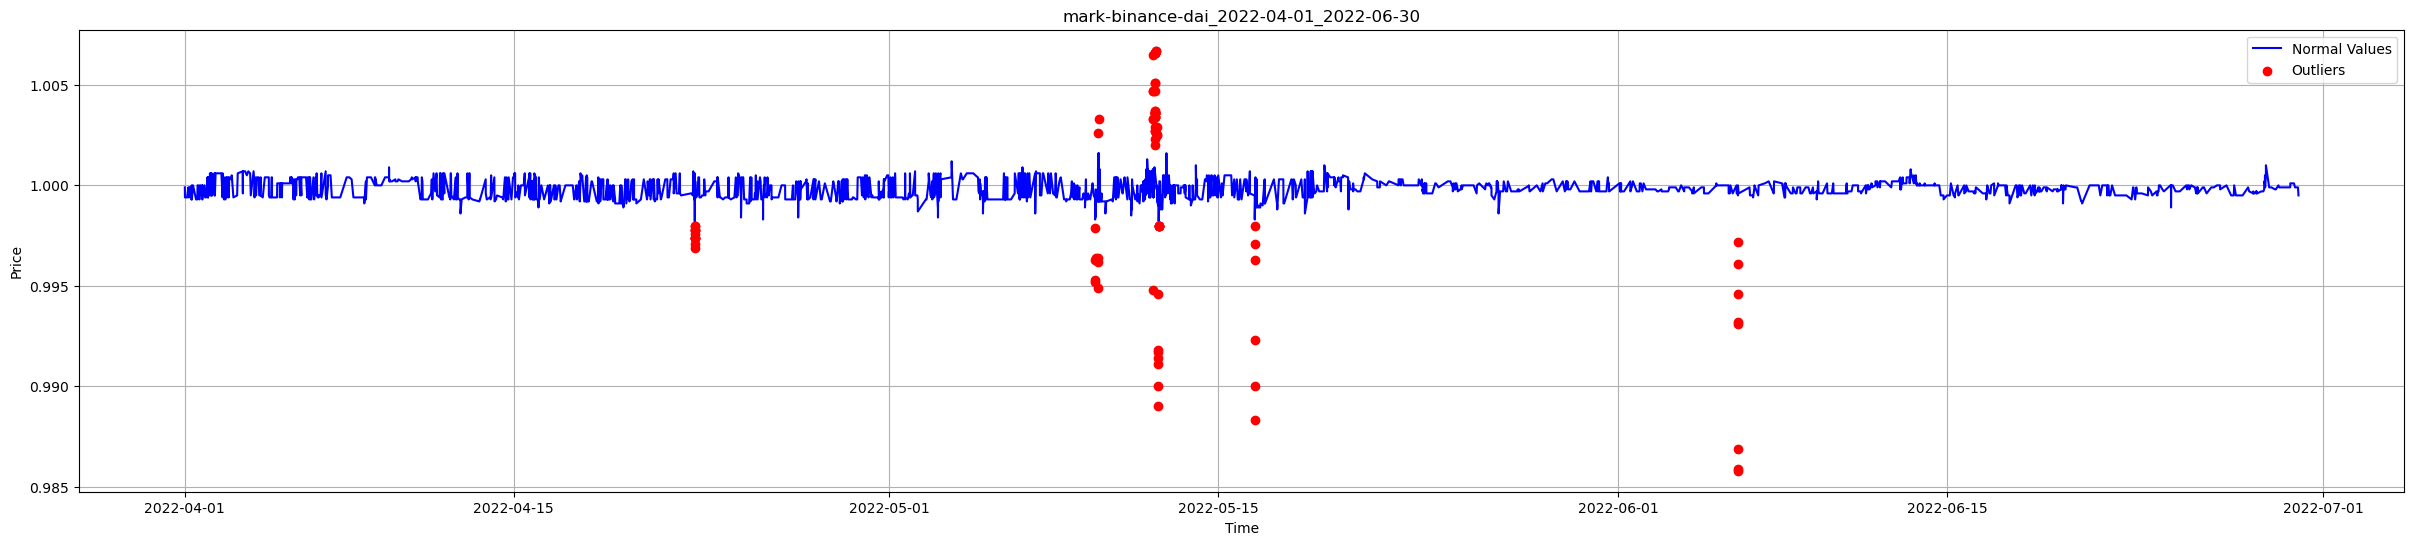

Index(['market', 'time', 'coin_metrics_id', 'amount', 'price', 'database_time',
       'side', 'price_outlier'],
      dtype='object')
ok


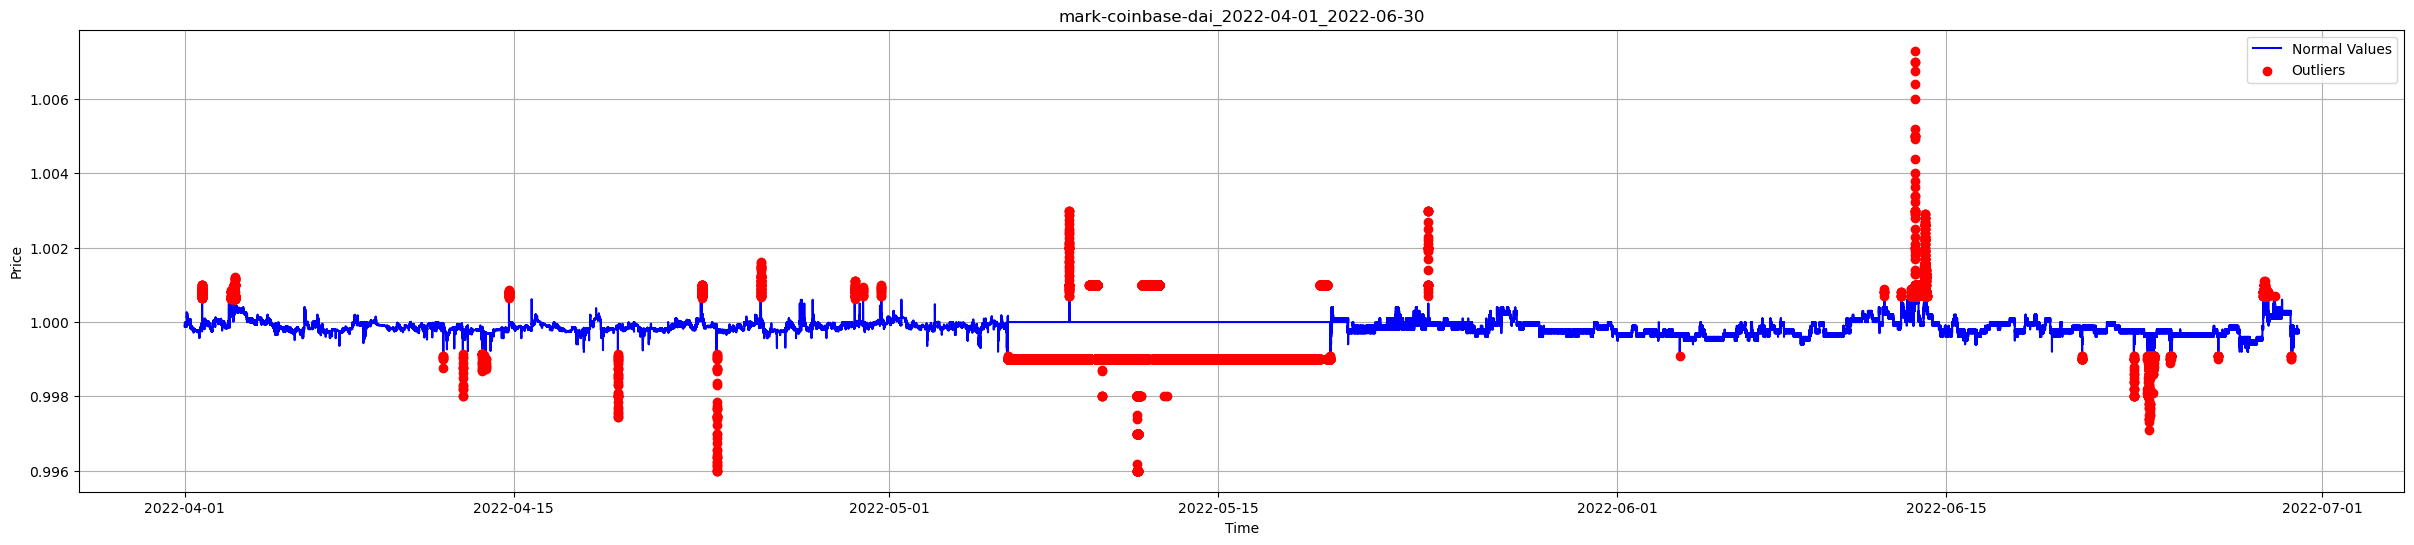

In [14]:
plot_stablecoin_prices("mark-binance-dai_2022-04-01_2022-06-30","mark-binance-dai_2022-04-01_2022-06-30",dataframes)
plot_stablecoin_prices("mark-coinbase-dai_2022-04-01_2022-06-30","mark-coinbase-dai_2022-04-01_2022-06-30",dataframes)

### Pour Ftx, la suppresion d'outlier n'est pas très pertinente pour le moment 

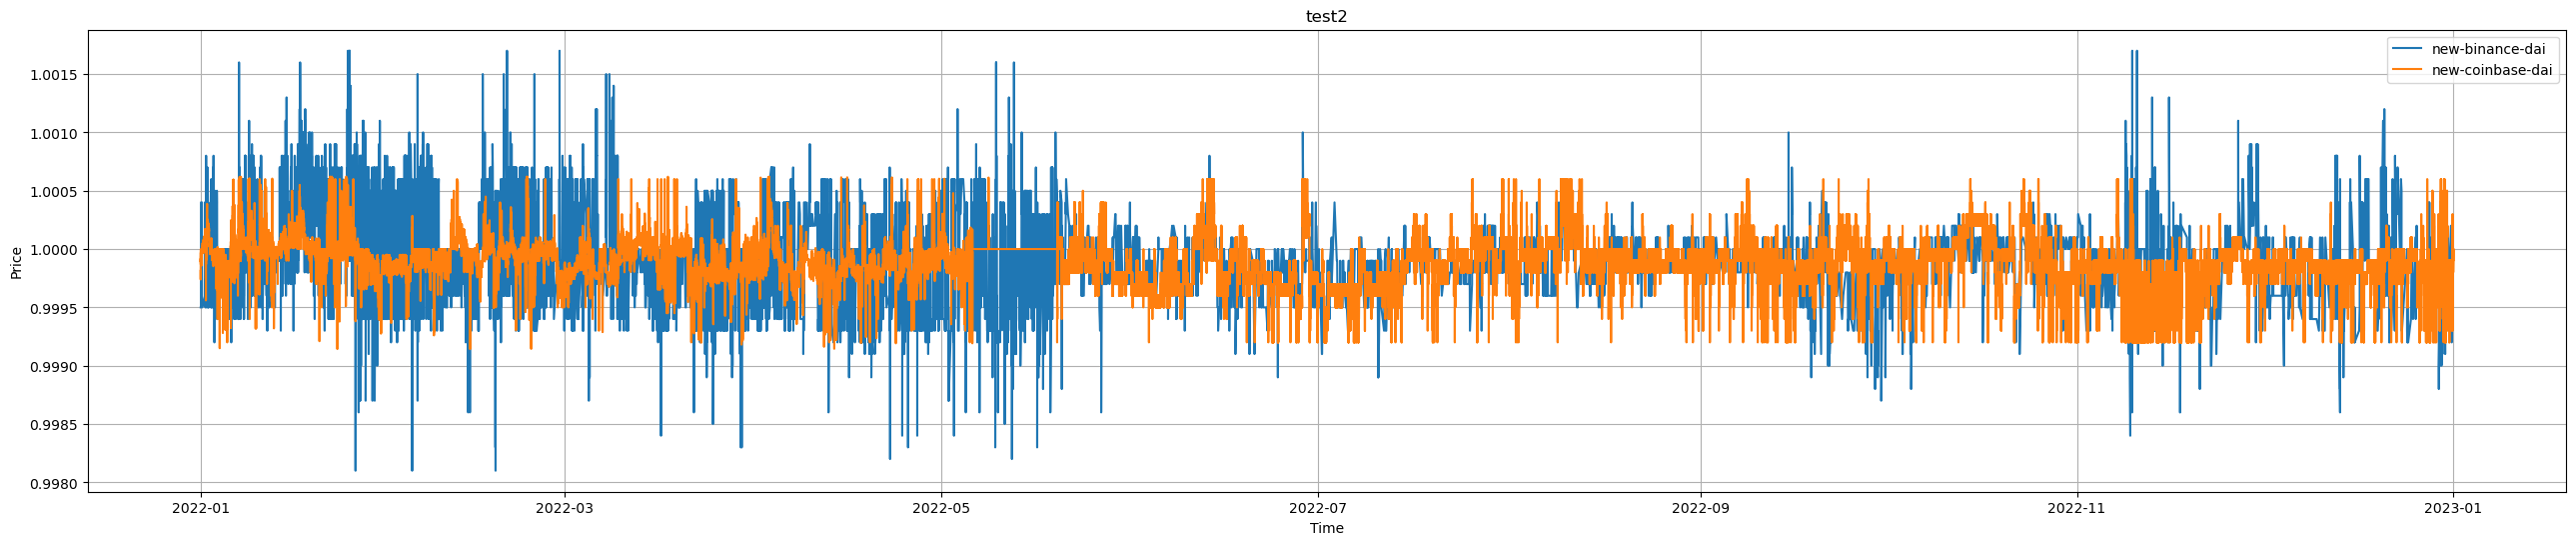

In [43]:
plot_stablecoin_prices_multi(["new-binance-dai","new-coinbase-dai"],"test2",dataframes)

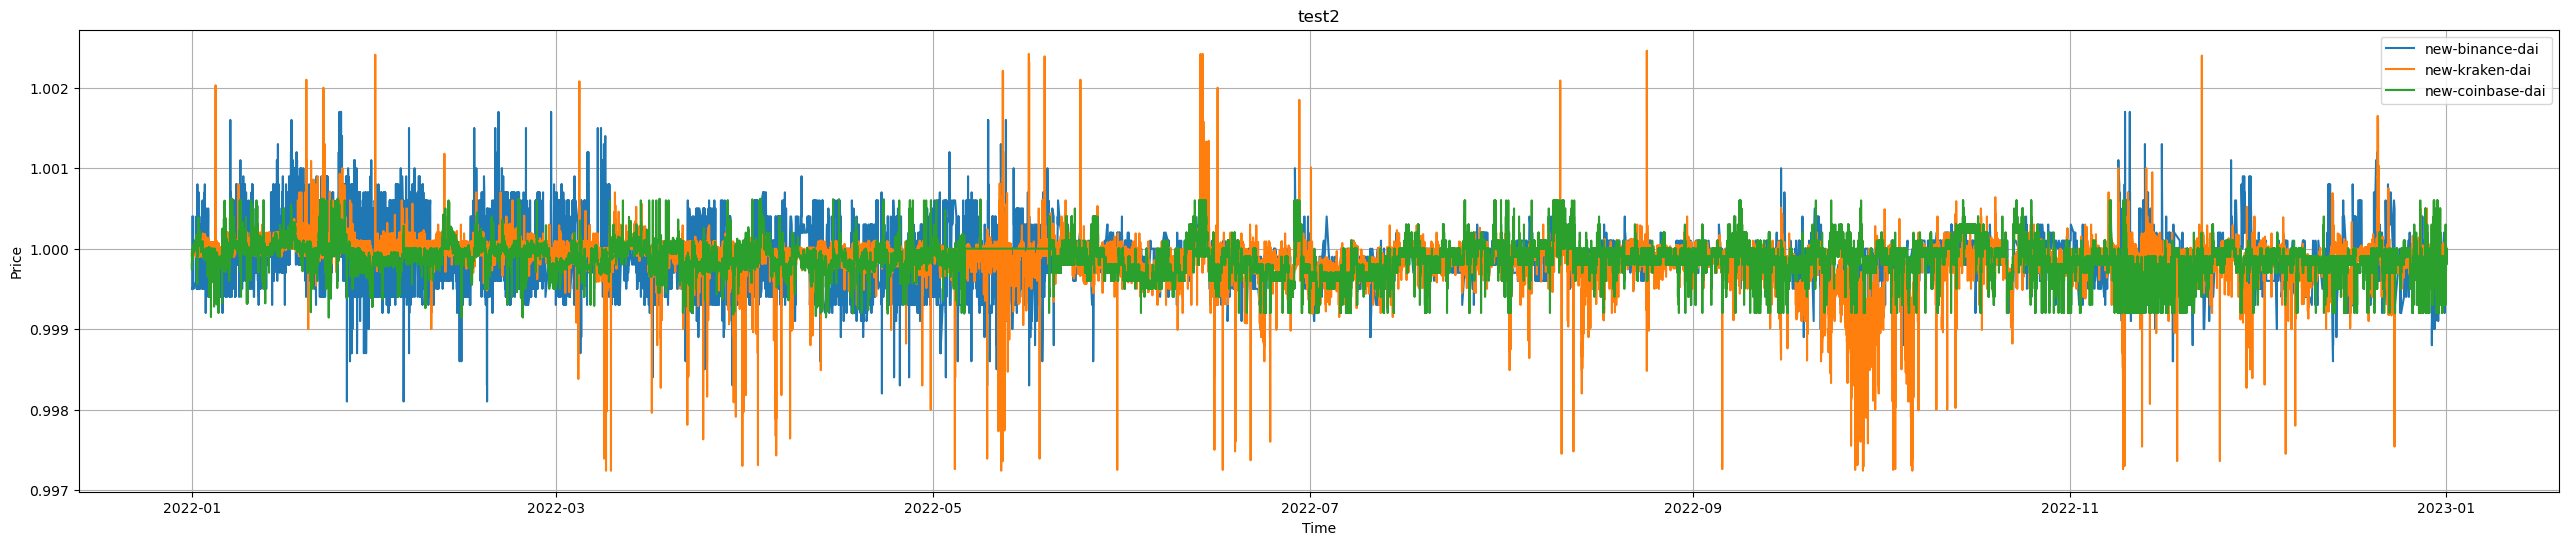

In [49]:
plot_stablecoin_prices_multi(["new-binance-dai","new-kraken-dai","new-coinbase-dai"],"test2",dataframes)
# plot_stablecoin_prices_multi(["new-binance-dai","new-coinbase-dai","new-ftx-dai","new-kraken-dai"],"test2",dataframes)

### On a uniquement superposé les courbes de coinbase et binance, on remarque que les valeurs proches de mai 2022 sont considérés comme outlier pour coinbase pour un écart type de 3

## Pour FTX, on rapplique une suppression des outlier

price: 1742 outliers removed


/tmp/ipykernel_79185/1404270565.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


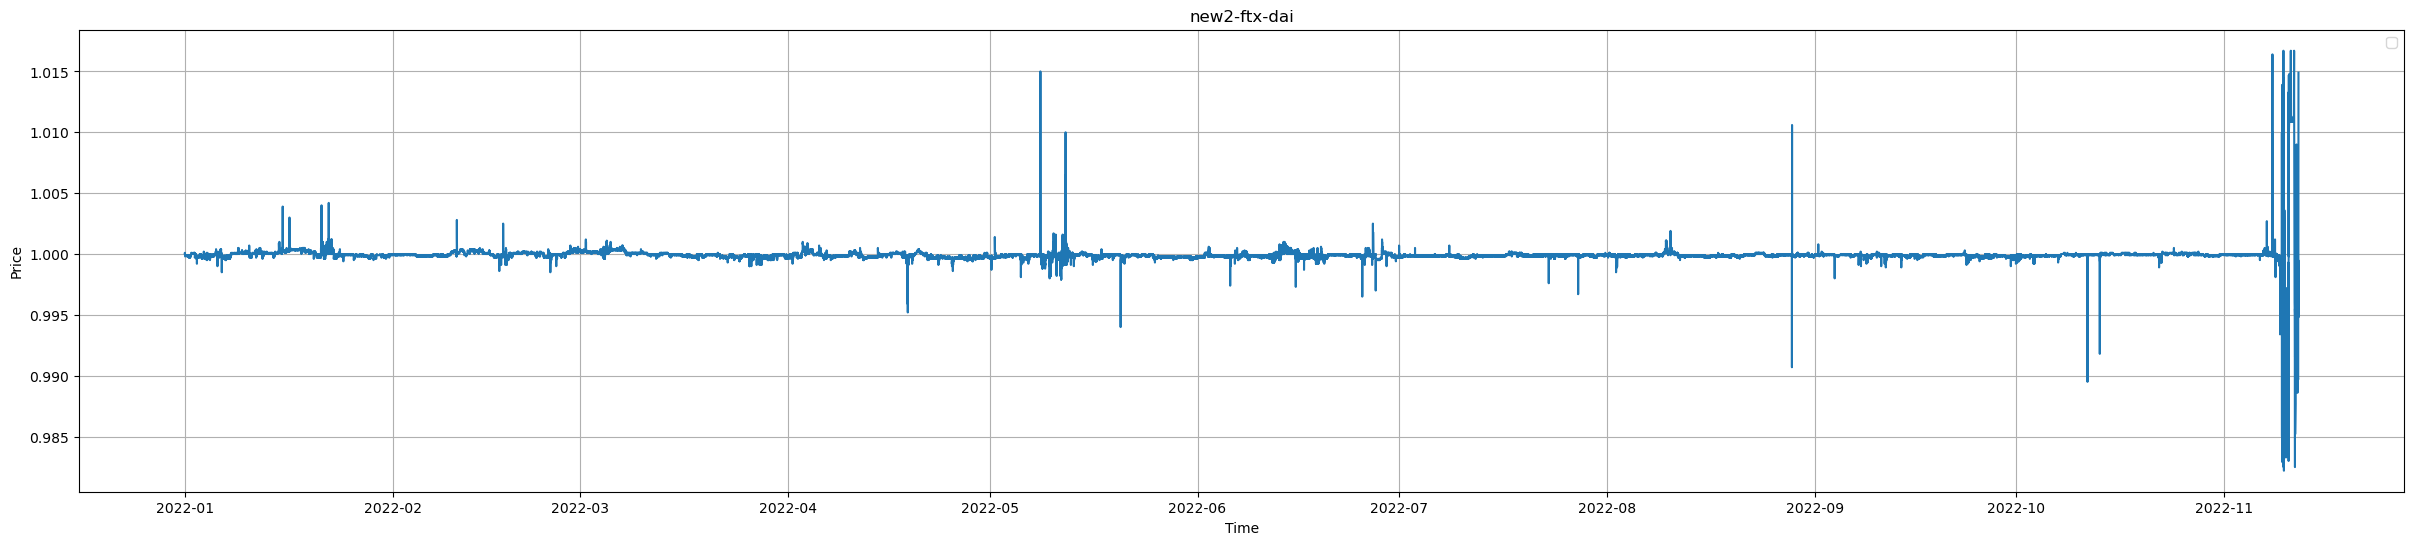

In [10]:
dataframes["new2-ftx-dai"] = remove_outliers(dataframes["new-ftx-dai"], ["price"])
plot_stablecoin_prices("new2-ftx-dai","new2-ftx-dai",dataframes)

## On applique encore une fois 

price: 2024 outliers removed


/tmp/ipykernel_79185/1404270565.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


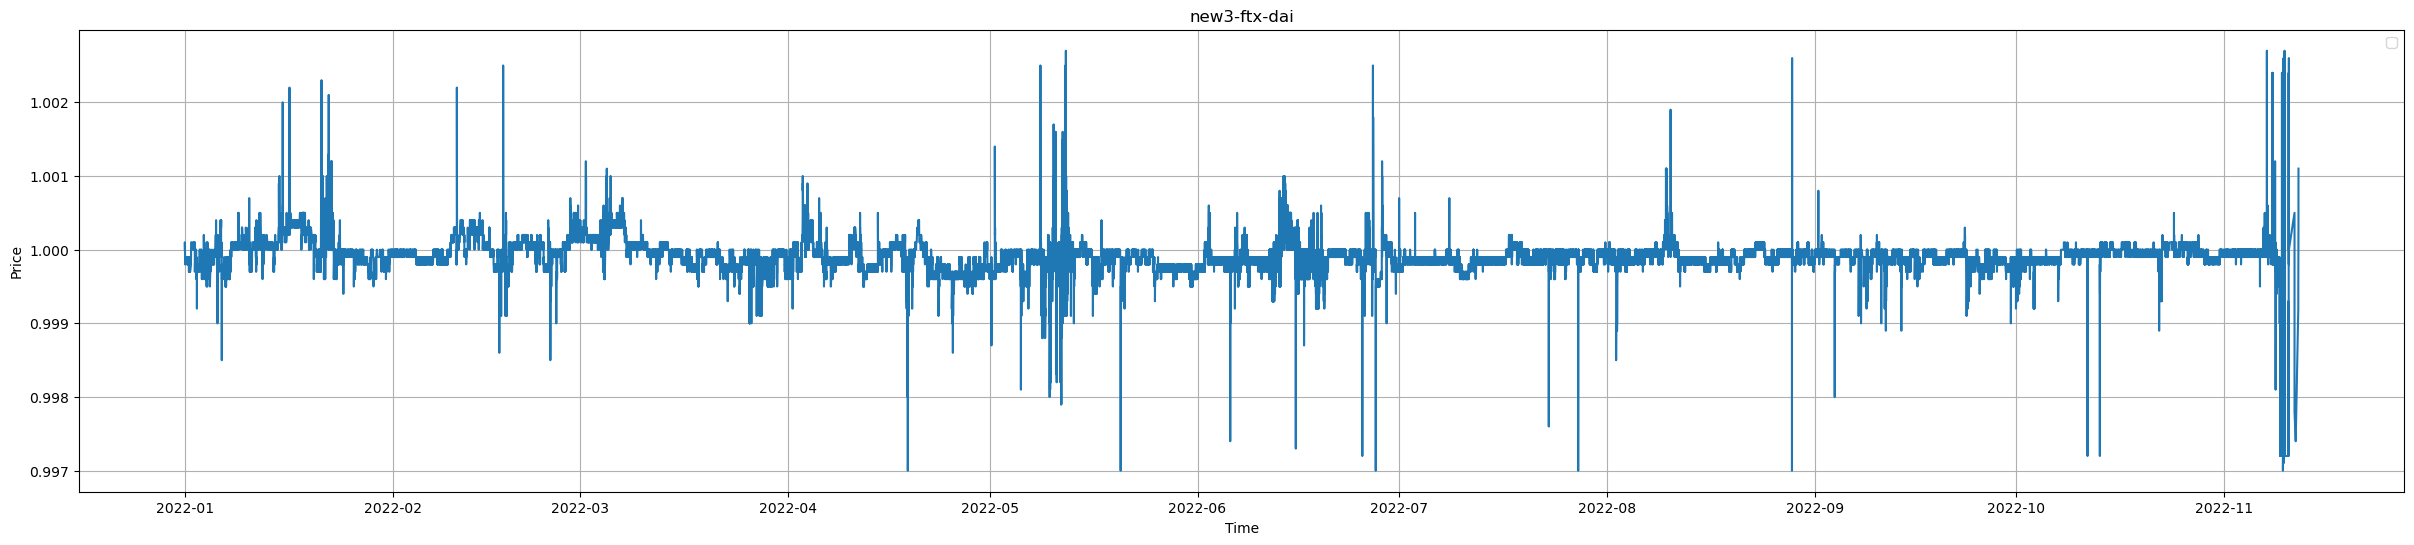

In [11]:
dataframes["new3-ftx-dai"] = remove_outliers(dataframes["new2-ftx-dai"], ["price"])
plot_stablecoin_prices("new3-ftx-dai","new3-ftx-dai",dataframes)

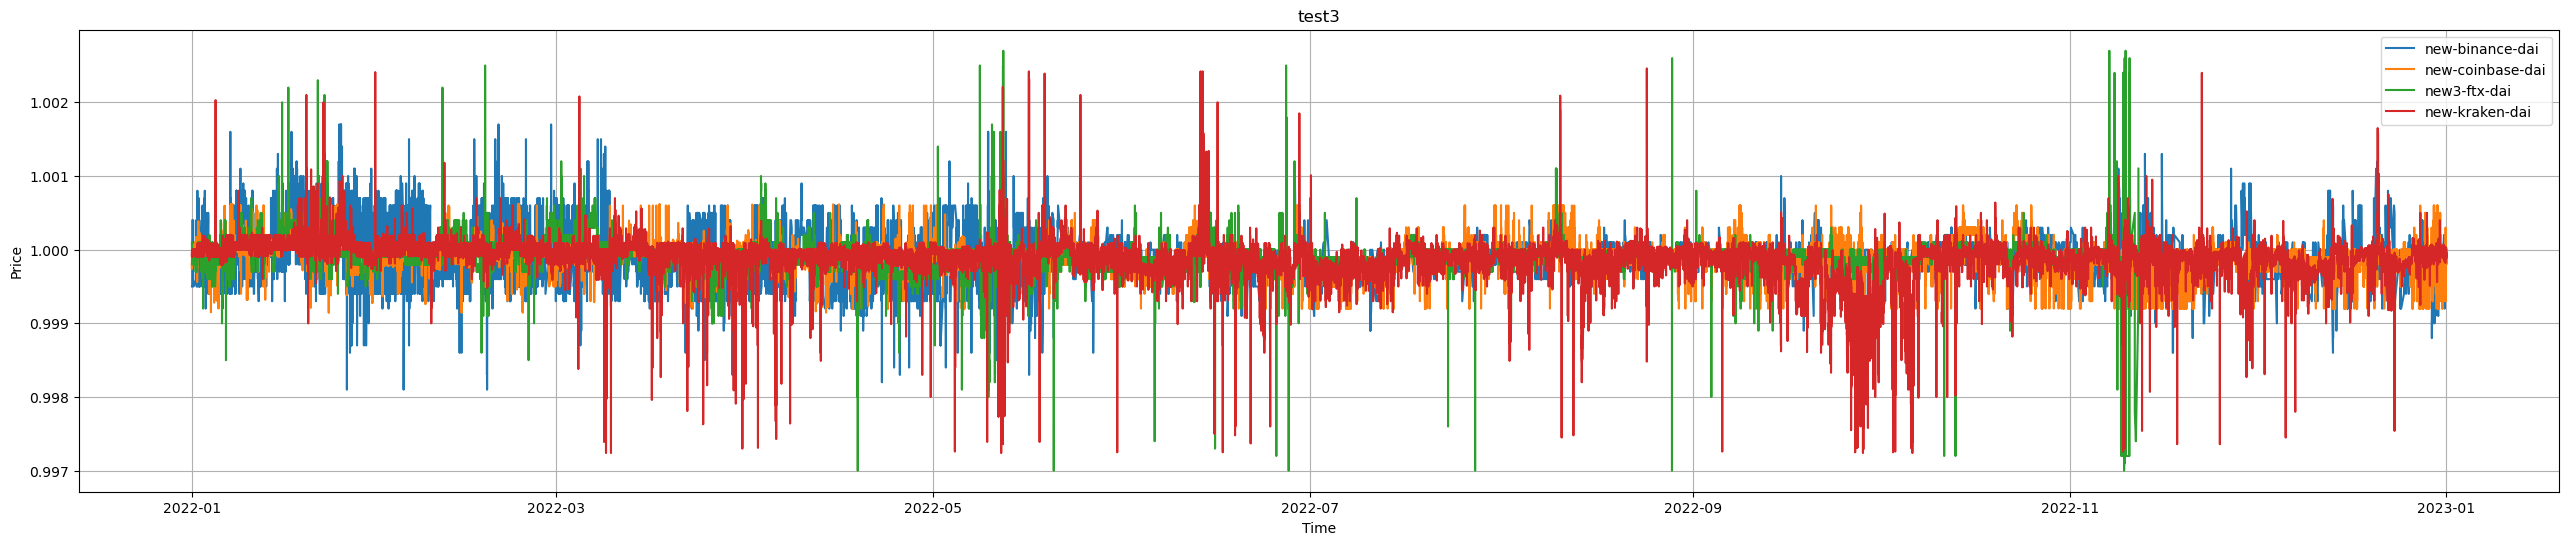

In [12]:
plot_stablecoin_prices_multi(["new-binance-dai","new-coinbase-dai","new3-ftx-dai","new-kraken-dai"],"test3",dataframes)

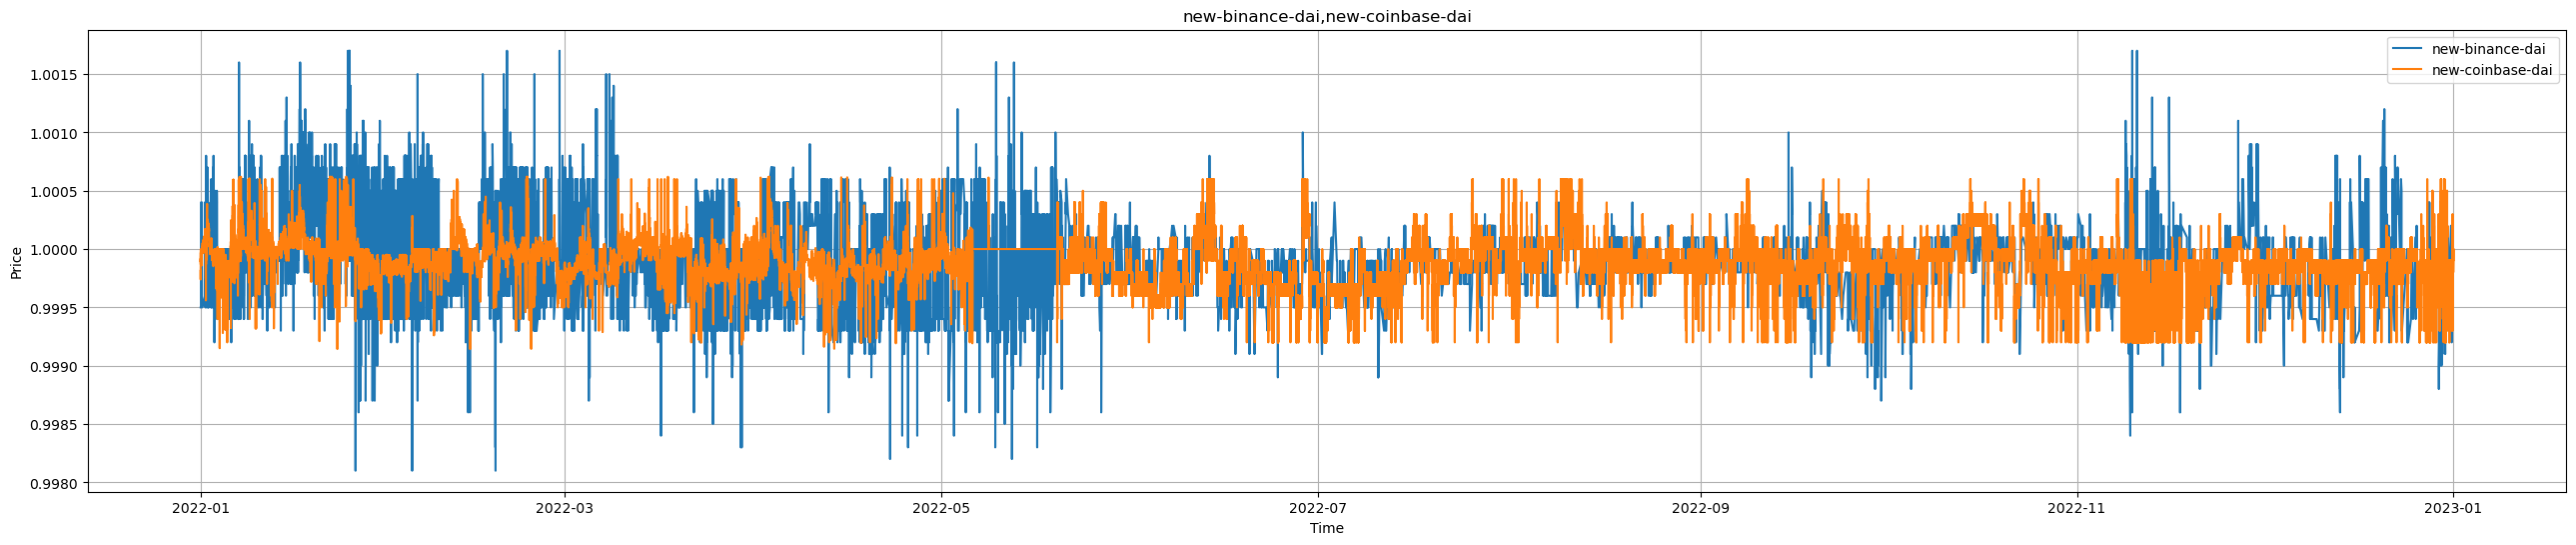

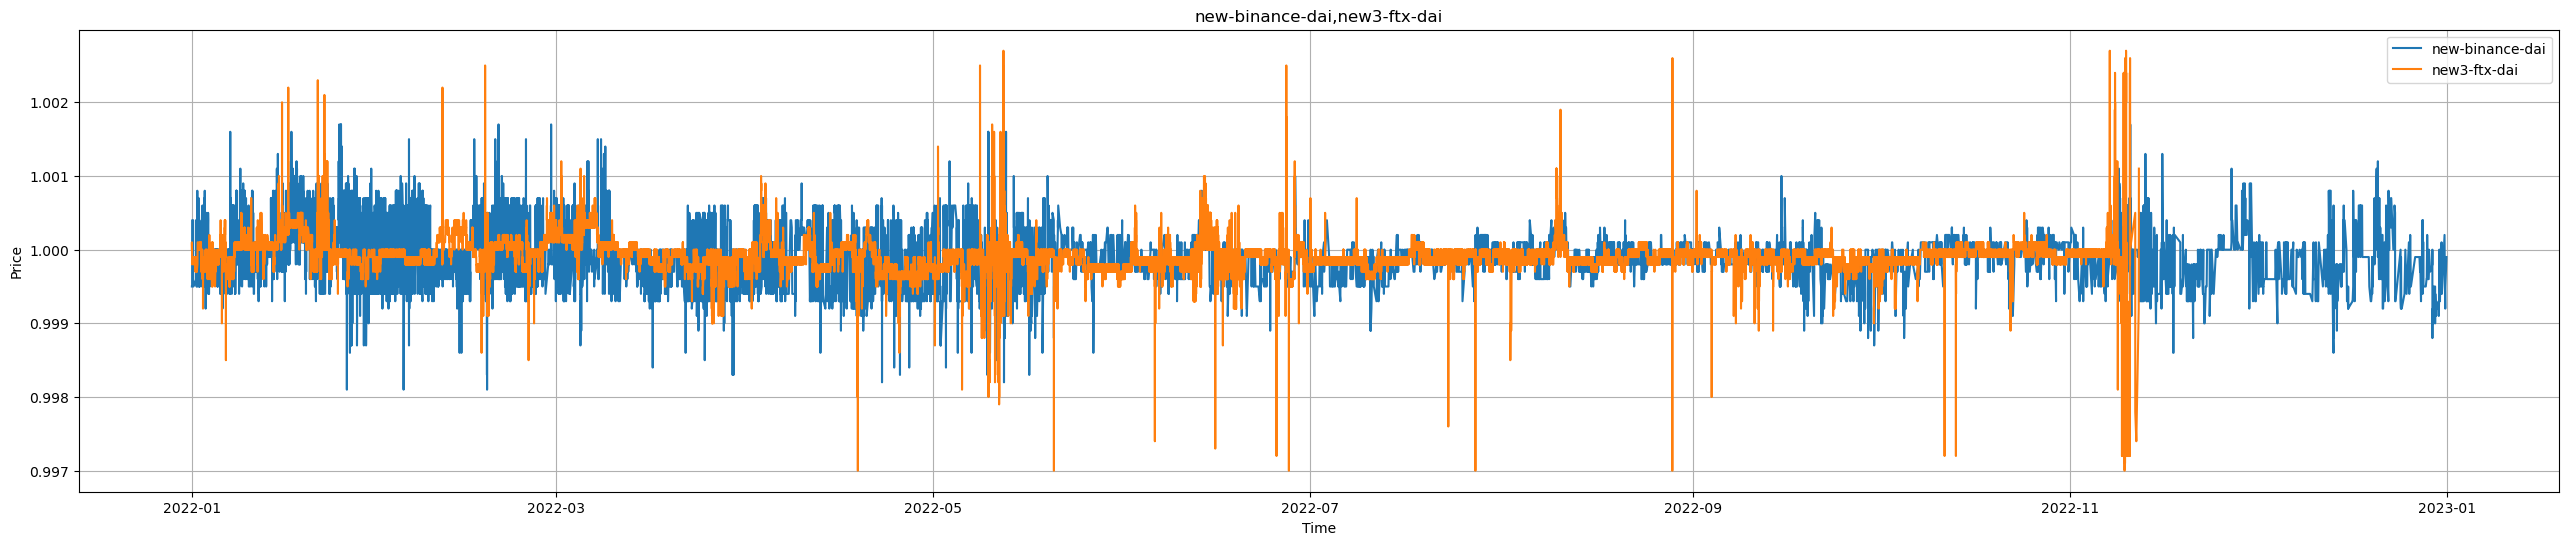

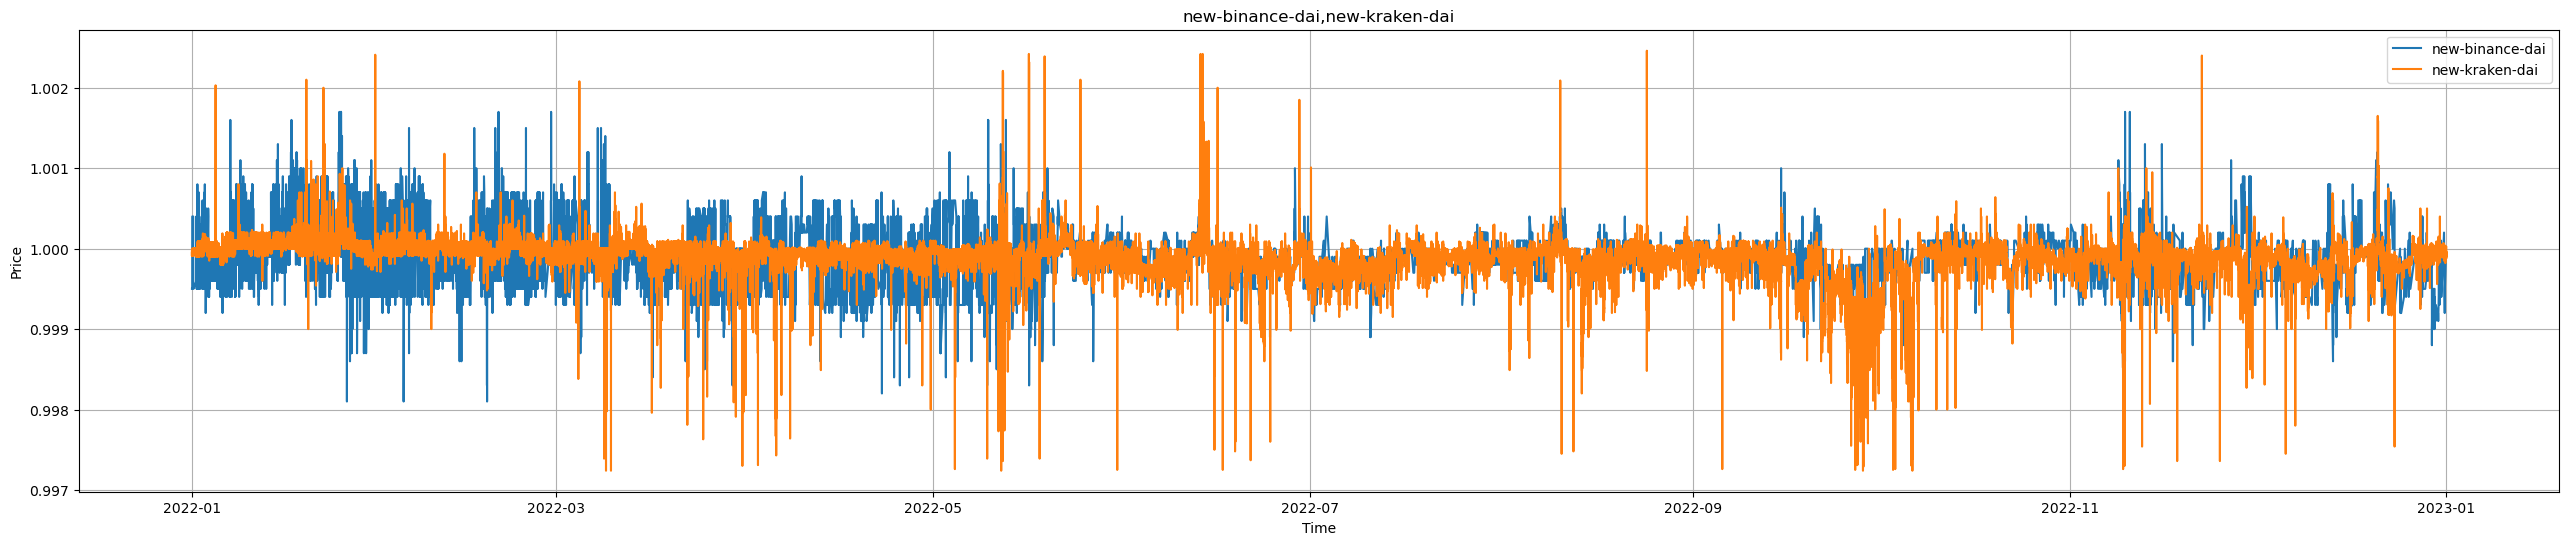

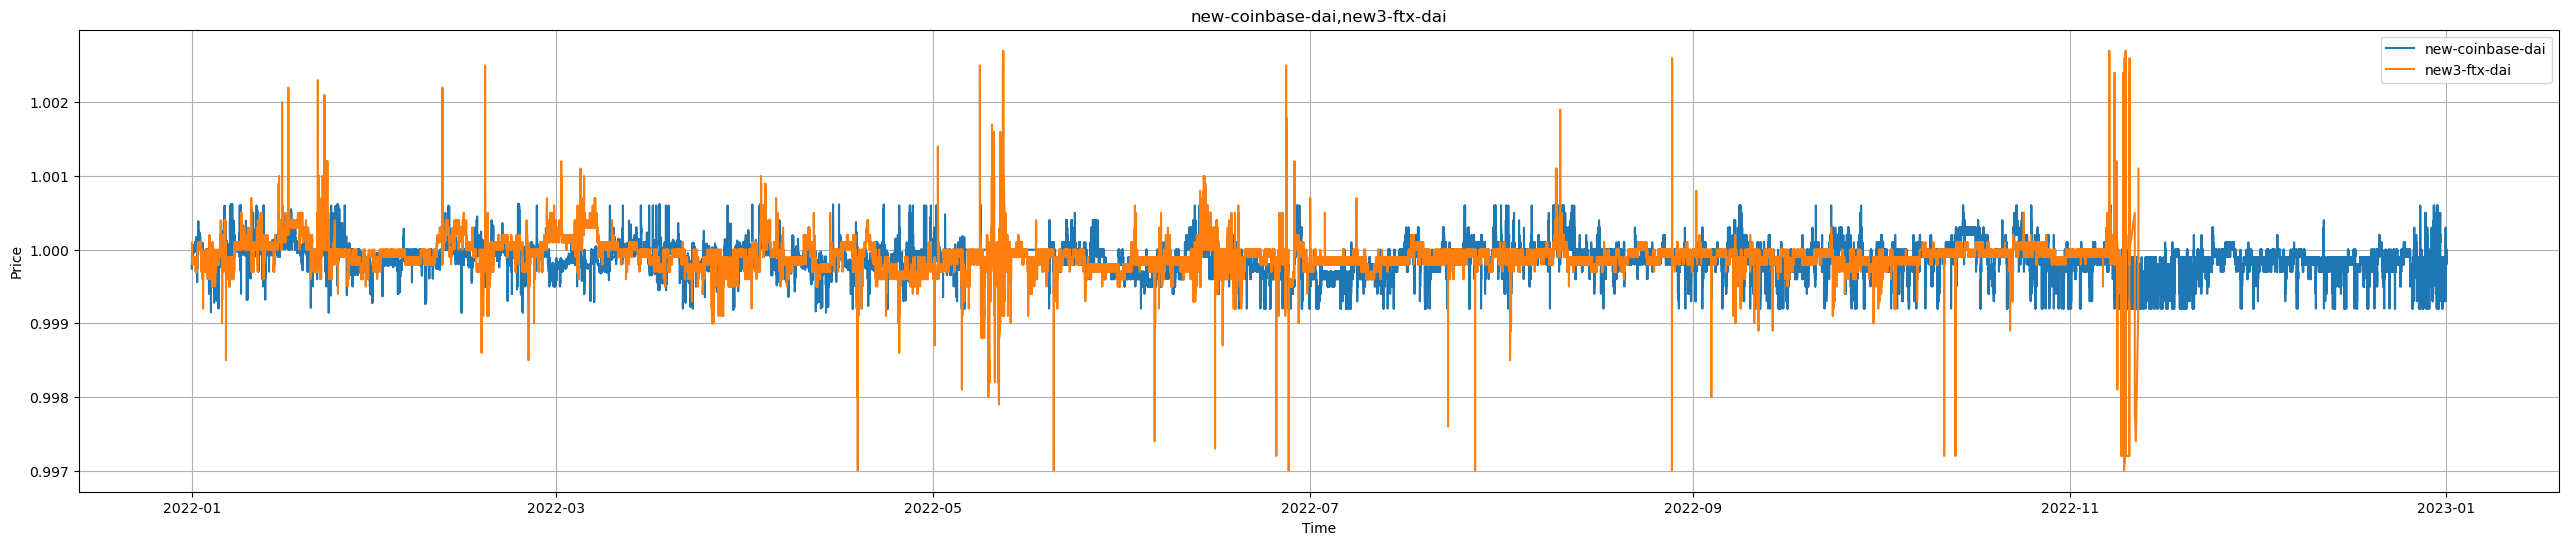

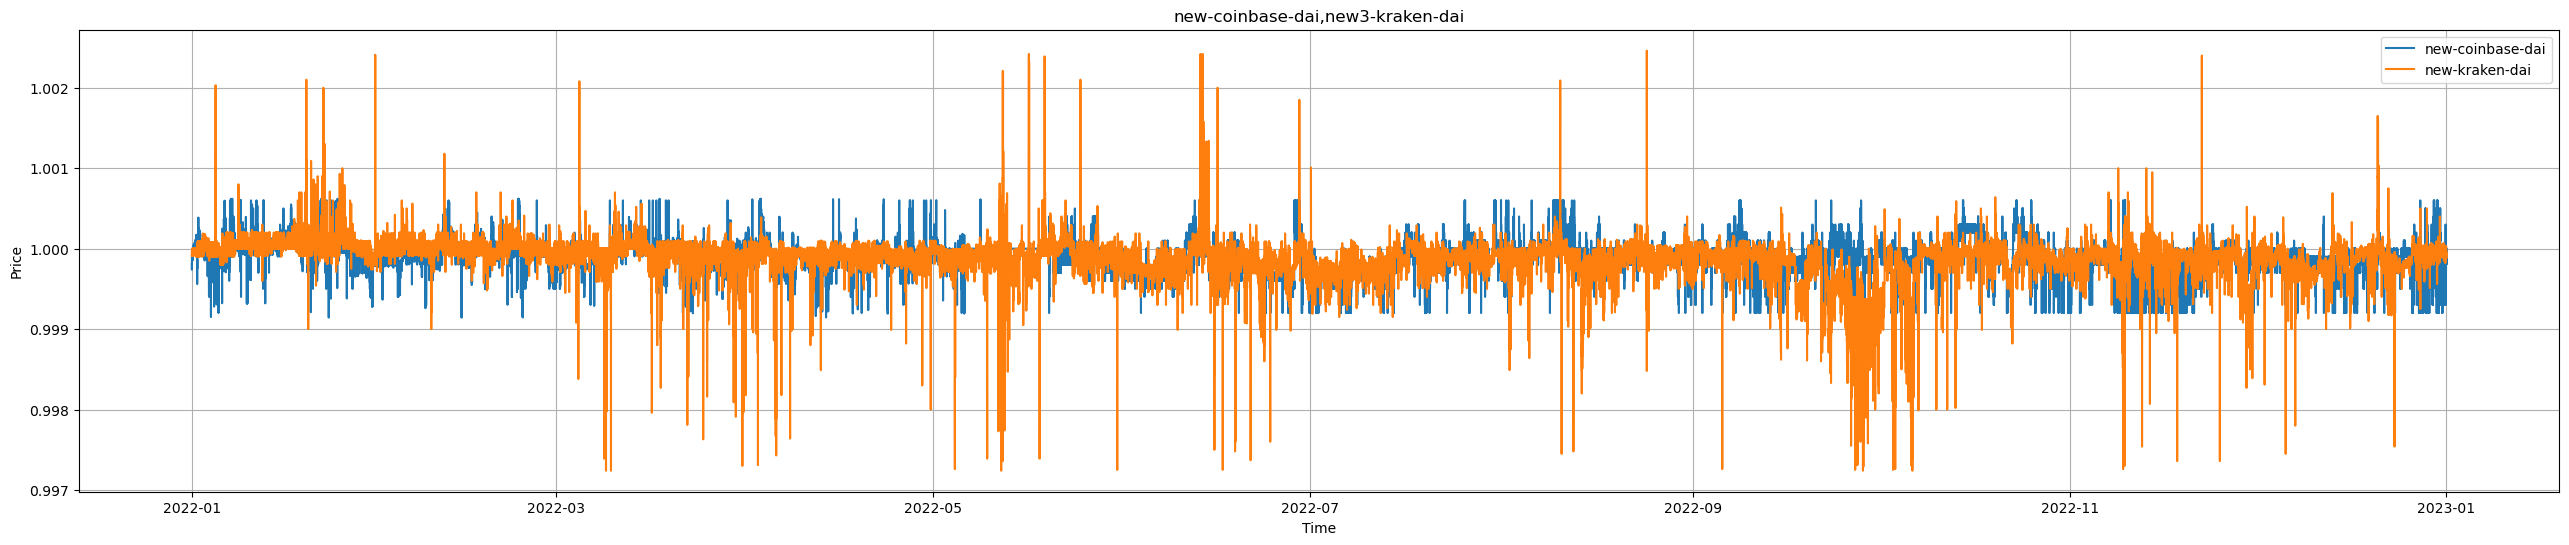

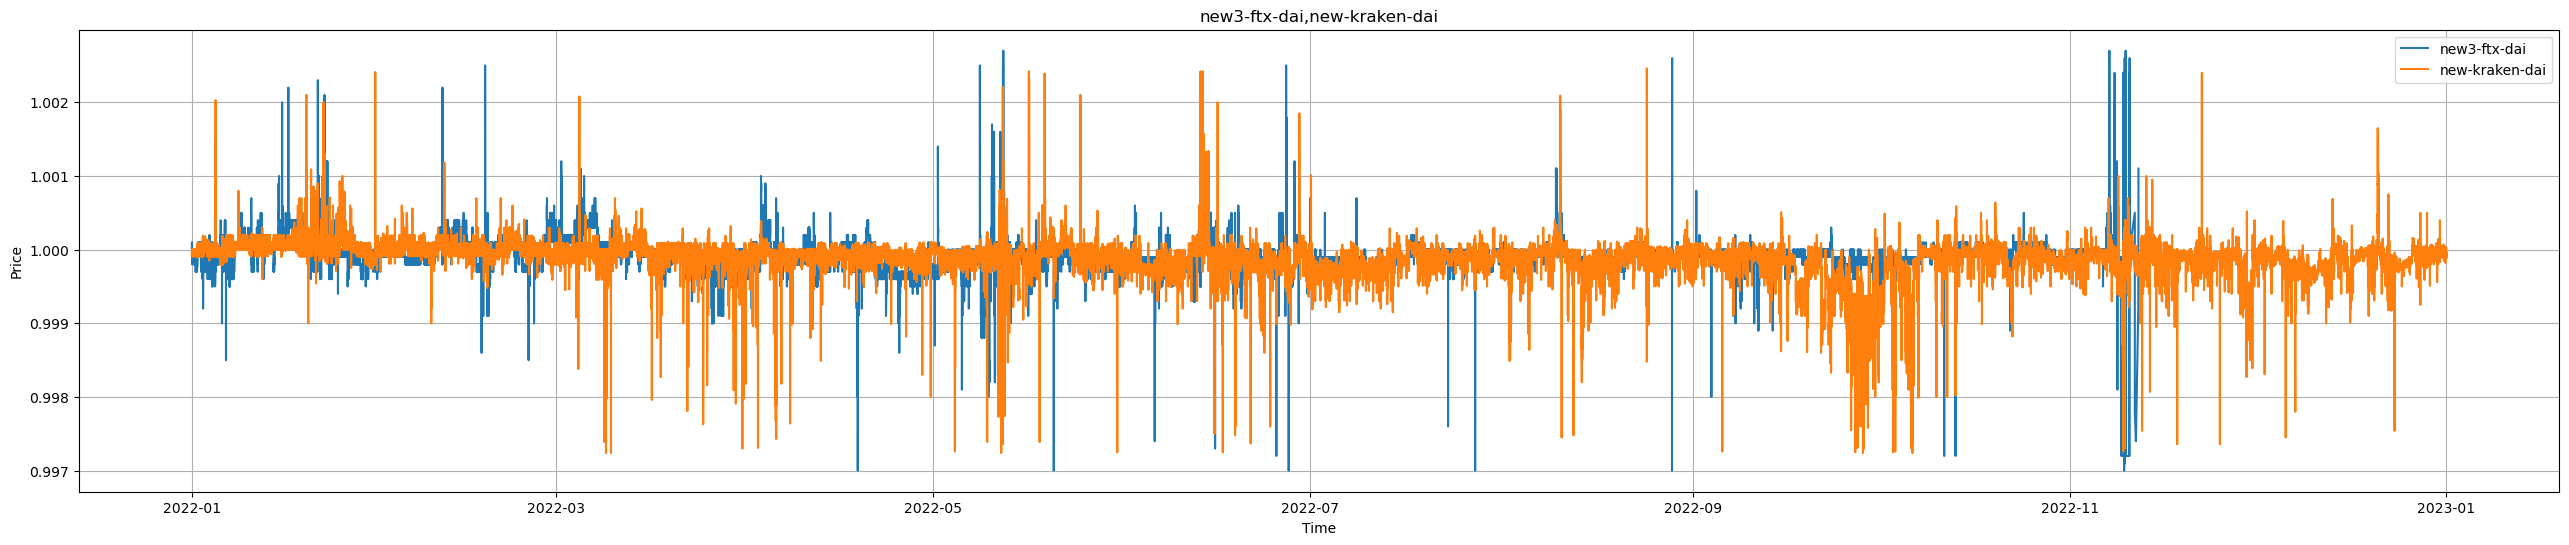

In [15]:
plot_stablecoin_prices_multi(["new-binance-dai","new-coinbase-dai"],"new-binance-dai,new-coinbase-dai",dataframes)
plot_stablecoin_prices_multi(["new-binance-dai","new3-ftx-dai"],"new-binance-dai,new3-ftx-dai",dataframes)
plot_stablecoin_prices_multi(["new-binance-dai","new-kraken-dai"],"new-binance-dai,new-kraken-dai",dataframes)
plot_stablecoin_prices_multi(["new-coinbase-dai","new3-ftx-dai"],"new-coinbase-dai,new3-ftx-dai",dataframes)
plot_stablecoin_prices_multi(["new-coinbase-dai","new-kraken-dai"],"new-coinbase-dai,new3-kraken-dai",dataframes)
plot_stablecoin_prices_multi(["new3-ftx-dai","new-kraken-dai"],"new3-ftx-dai,new-kraken-dai",dataframes)
